In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
from models.Attention3DUNet import Attention3UNet
from models.Base3DUNet import Base3DUNet
from models.Residual3DUNet import Res3DUNet
from util.data import get_dl, get_val_ds
from util.training_utils import load, get_all_metrics_2

BATCH_SIZE = 4
EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_dl = get_dl(get_val_ds(full_masks=True), BATCH_SIZE, nw=2)

images: 148, masks: 148 


In [2]:
def show_roc(fpr, tpr, roc_auc, name="example"):
    fig, ax = plt.subplots(1, 1)
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {name}')
    ax.legend(loc="lower right")
    plt.show()


def calc_show_roc(results):

    fpr_TC, tpr_TC, _ = roc_curve(np.array(results['TC']['real']).reshape(-1), np.array(results['TC']['pred']).reshape(-1))
    roc_auc_TC = auc(fpr_TC, tpr_TC)
    show_roc(fpr_TC, tpr_TC, roc_auc_TC, name="TC")

    fpr_ET, tpr_ET, _ = roc_curve(np.array(results['ET']['real']).reshape(-1), np.array(results['ET']['pred']).reshape(-1))
    roc_auc_ET = auc(fpr_ET, tpr_ET)
    show_roc(fpr_ET, tpr_ET, roc_auc_ET, name="ET")

    fpr_WT, tpr_WT, _ = roc_curve(np.array(results['WT']['real']).reshape(-1), np.array(results['WT']['pred']).reshape(-1))
    roc_auc_WT = auc(fpr_WT, tpr_WT)
    show_roc(fpr_WT, tpr_WT, roc_auc_WT, name="WT")

def metrics(dataloader, model, device='cuda'):
    res = get_all_metrics_2(dataloader, model, device)
    calc_show_roc(res)
    del res

In [3]:
import gc


def clear():
    torch.cuda.empty_cache()
    gc.collect()


clear()

In [4]:
sample_x = val_dl.dataset[93][0]
sample_y = val_dl.dataset[93][1][:,::2,::2,::2]
n_slice = [21,22,42]

def visualize(pred):
    plt.figure(figsize=(12,12))
    plt.subplot(331)
    plt.imshow(pred[0,:,n_slice[1]], cmap='gray')
    plt.title('NCR/NET Correct mask - front')
    plt.subplot(332)
    plt.imshow(pred[0,n_slice[0],:].squeeze(), cmap='gray')
    plt.title('NCR/NET Correct mask - side')
    plt.subplot(333)
    plt.imshow(pred[0,:,:,n_slice[2]].squeeze(), cmap='gray')
    plt.title('NCR/NET Correct mask - top')

    plt.subplot(334)
    plt.imshow(pred[1,:,n_slice[1]], cmap='gray')
    plt.title('ED Correct mask - front')
    plt.subplot(335)
    plt.imshow(pred[1,n_slice[0],:].squeeze(), cmap='gray')
    plt.title('ED Correct mask - side')
    plt.subplot(336)
    plt.imshow(pred[1,:,:,n_slice[2]].squeeze(), cmap='gray')
    plt.title('ED Correct mask - top')


    plt.subplot(337)
    plt.imshow(pred[2,:,n_slice[1]], cmap='gray')
    plt.title('ET Correct mask - front')
    plt.subplot(338)
    plt.imshow(pred[2,n_slice[0],:].squeeze(), cmap='gray')
    plt.title('ET Correct mask - side')
    plt.subplot(339)
    plt.imshow(pred[2,:,:,n_slice[2]].squeeze(), cmap='gray')
    plt.title('ET Correct mask - top')
    plt.show()

    plt.figure(figsize=(12,12))
    plt.subplot(331)
    plt.imshow(pred[0,:,n_slice[1]] | pred[2,:,n_slice[1]], cmap='gray')
    plt.title('TC Correct mask - front')
    plt.subplot(332)
    plt.imshow((pred[0,n_slice[0],:]|pred[2,n_slice[0],:] ).squeeze(), cmap='gray')
    plt.title('TC Correct mask - side')
    plt.subplot(333)
    plt.imshow((pred[0,:,:,n_slice[2]] | pred[0,:,:,n_slice[2]]).squeeze(), cmap='gray')
    plt.title('TC Correct mask - top')

    plt.subplot(334)
    plt.imshow(pred[2,:,n_slice[1]], cmap='gray')
    plt.title('ET Correct mask - front')
    plt.subplot(335)
    plt.imshow(pred[2,n_slice[0],:].squeeze(), cmap='gray')
    plt.title('ET Correct mask - side')
    plt.subplot(336)
    plt.imshow(pred[2,:,:,n_slice[2]].squeeze(), cmap='gray')
    plt.title('ET Correct mask - top')


    plt.subplot(337)
    plt.imshow(pred[2,:,n_slice[1]] | pred[1,:,n_slice[1]] | pred[0,:,n_slice[1]], cmap='gray')
    plt.title('WT Correct mask - front')
    plt.subplot(338)
    plt.imshow((pred[2,n_slice[0],:] | pred[1,n_slice[0],:] | pred[0,n_slice[0],:]).squeeze(), cmap='gray')
    plt.title('WT Correct mask - side')
    plt.subplot(339)
    plt.imshow((pred[2,:,:,n_slice[2]] | pred[1,:,:,n_slice[2]] | pred[0,:,:,n_slice[2]]).squeeze(), cmap='gray')
    plt.title('WT Correct mask - top')
    plt.show()

def visualize_model(model, sample_x):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(sample_x.unsqueeze(0))
        x = x.to(DEVICE)
        # torch.tensor(sample_y.unsqueeze(0)).to
        pred = (torch.sigmoid(model(x)) > 0.5).float()
    model.train()
    visualize(pred.cpu().detach().numpy().squeeze().astype("bool"))

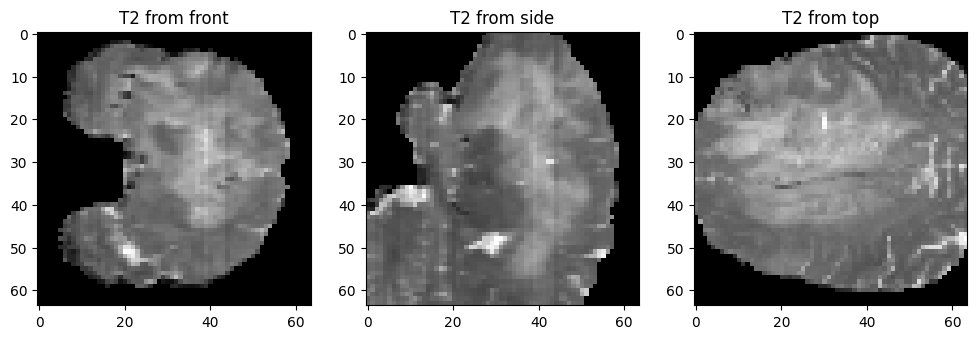

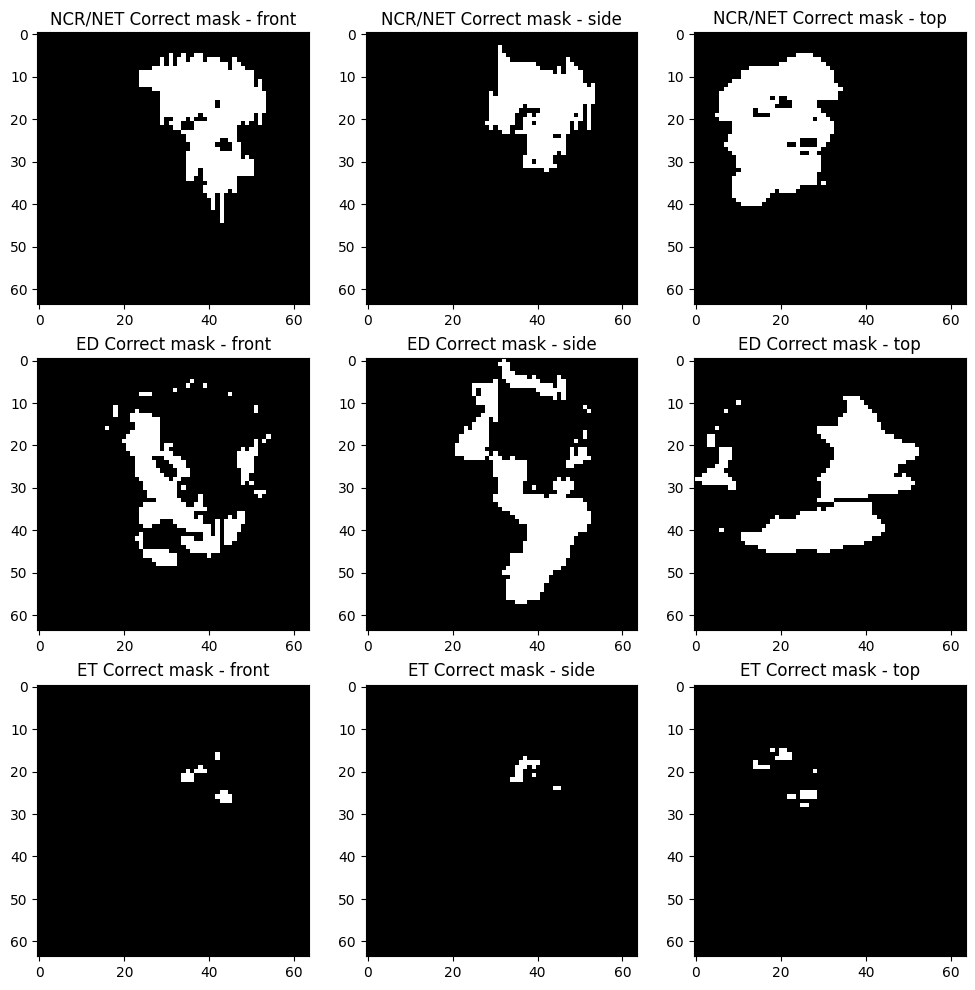

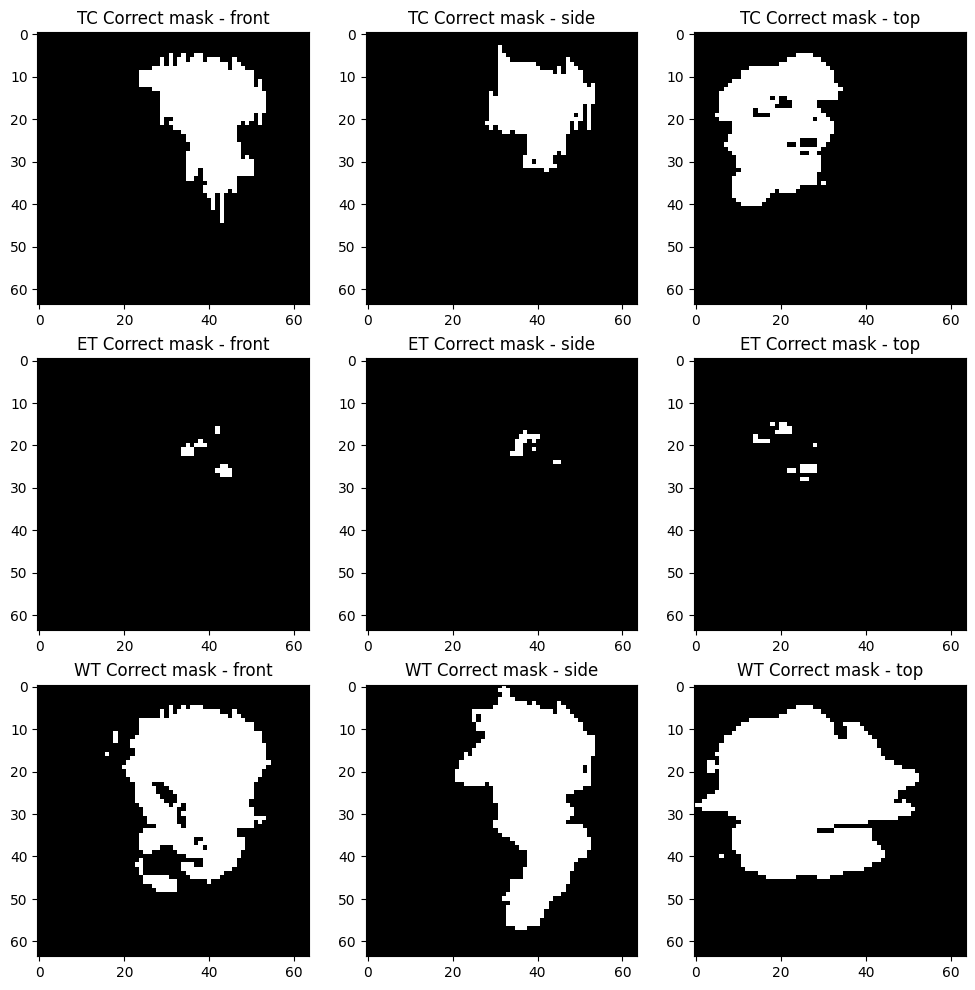

In [5]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(sample_x[2,:,n_slice[1]], cmap='gray')
plt.title('T2 from front')
plt.subplot(132)
plt.imshow(sample_x[2,n_slice[0],:].squeeze(), cmap='gray')
plt.title('T2 from side')
plt.subplot(133)
plt.imshow(sample_x[2,:,:,n_slice[2]].squeeze(), cmap='gray')
plt.title('T2 from top')
plt.show()

visualize(sample_y)

In [6]:
model = Base3DUNet(3, 3, features=[64, 128, 256, 512], up_sample=True).to(DEVICE)
print(f"total learnable parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

total learnable parameters = 94130947


C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


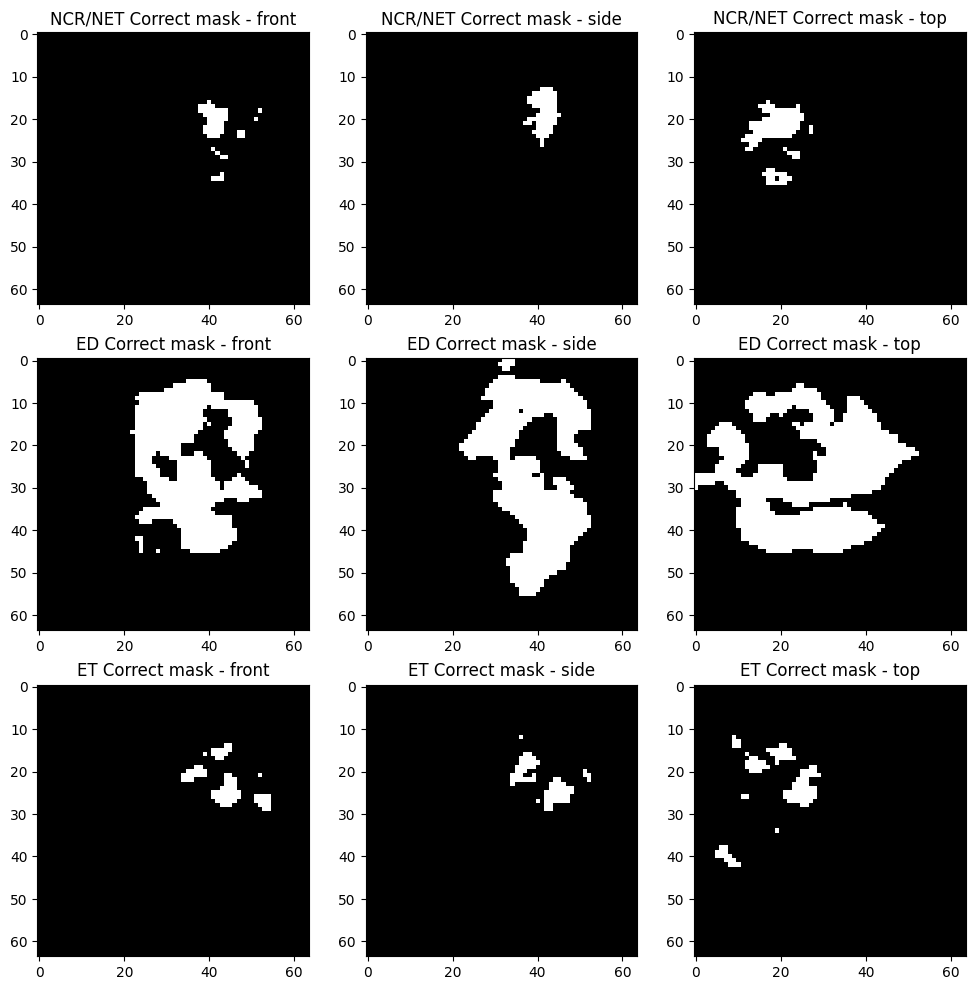

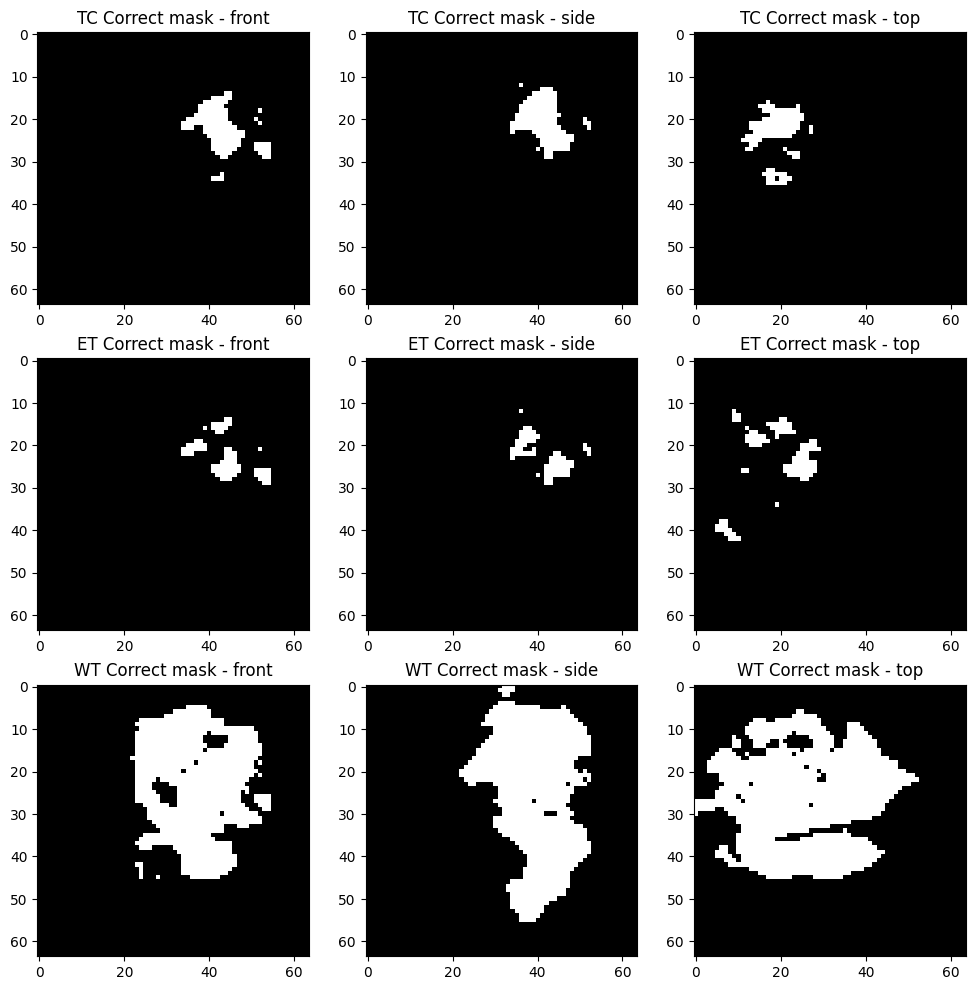

3DUNet Upsampler with Dice Loss
 Accuracy (TC,ET,WT): 
 99.3687 , 99.6902, 99.0624
Dice Score (TC,ET,WT): 
 0.7862443923950195 , 0.6888573169708252, 0.847997784614563
IoU Score (TC,ET,WT): 
 0.6910542249679565 , 0.5777106881141663, 0.7646352648735046
 Precision (TC,ET,WT): 
 --> 39.9044 , 80.0799, 16.3580
 Recall (TC,ET,WT): 
 --> 34.6580 , 78.0800, 14.9038
 F1-score (TC,ET,WT): 
 --> 37.0966 , 79.0673, 15.5971


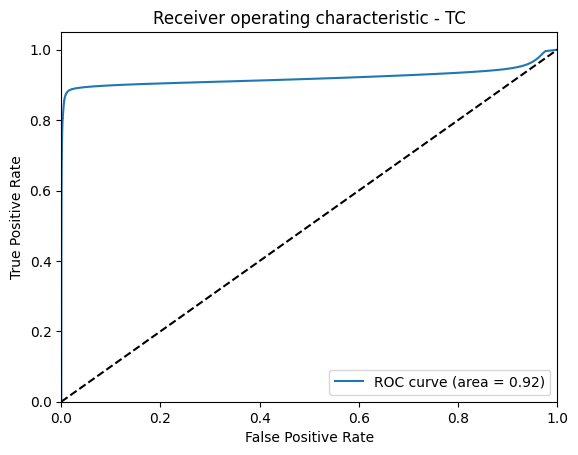

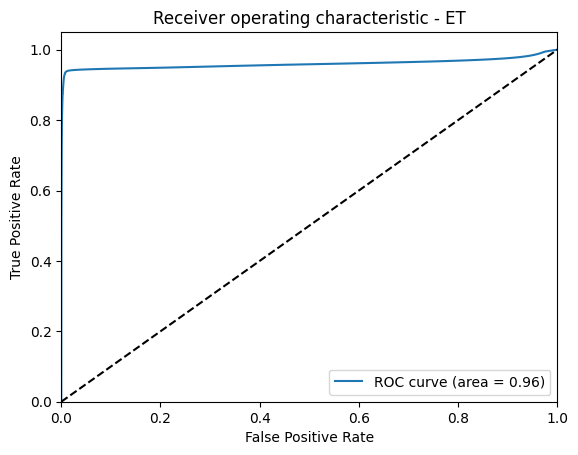

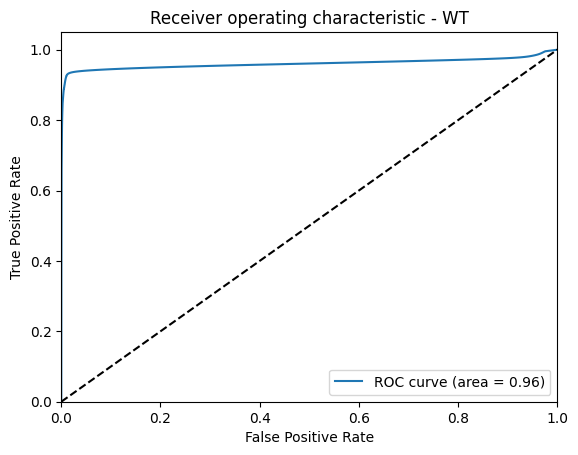

In [7]:
load(model, "weights/3D/3d_100e_adam_b4_dice_upsampler")
visualize_model(model, sample_x)
print("3DUNet Upsampler with Dice Loss")
metrics(val_dl, model, DEVICE)

C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


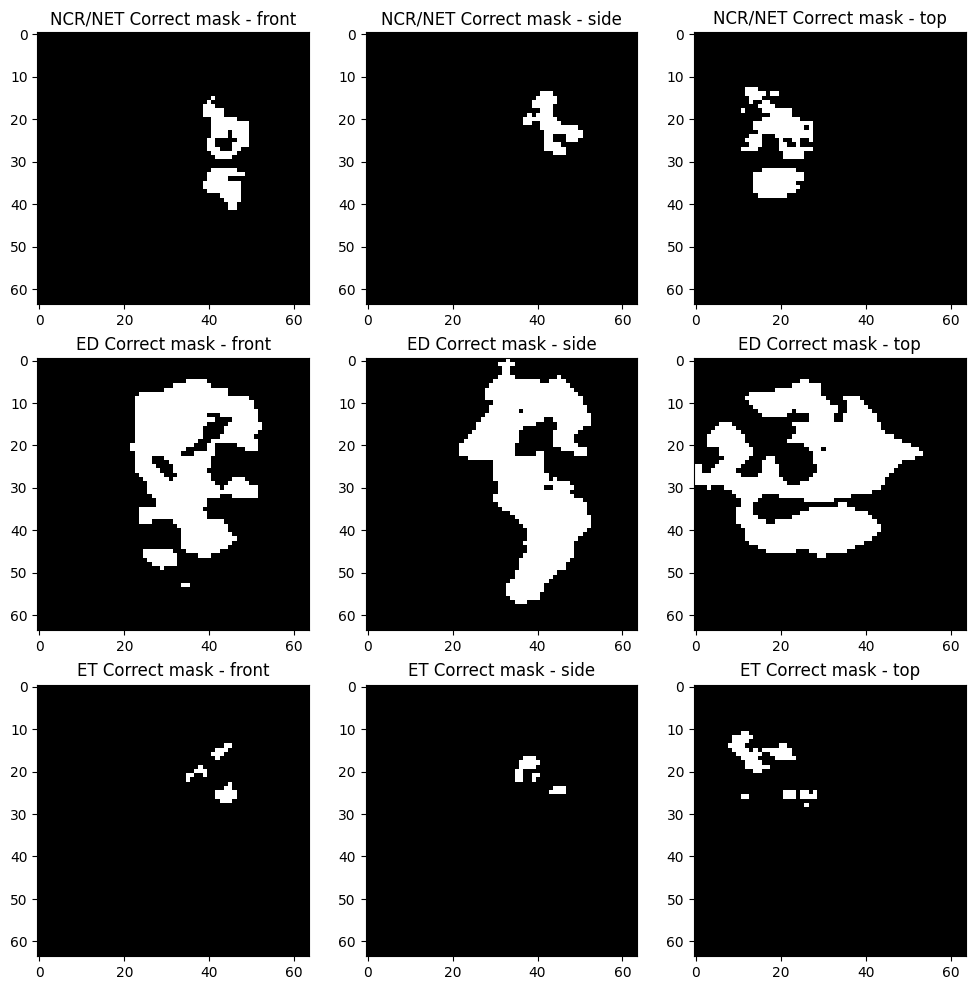

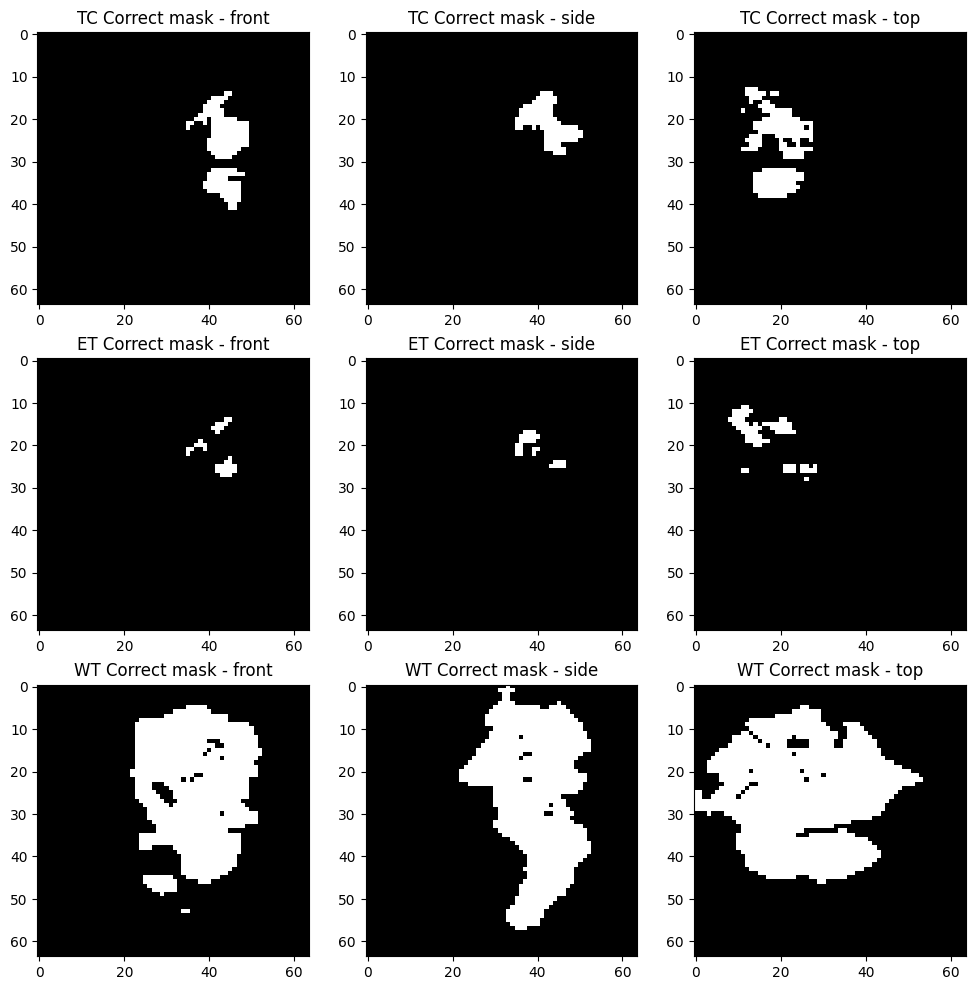

3DUNet Upsampler with BCE-Dice Loss
 Accuracy (TC,ET,WT): 
 99.3271 , 99.6928, 99.0894
Dice Score (TC,ET,WT): 
 0.7786939144134521 , 0.6890220046043396, 0.8575952649116516
IoU Score (TC,ET,WT): 
 0.67872154712677 , 0.5770221948623657, 0.7746961712837219
 Precision (TC,ET,WT): 
 --> 40.4647 , 84.0877, 15.7306
 Recall (TC,ET,WT): 
 --> 34.6435 , 78.0820, 14.9079
 F1-score (TC,ET,WT): 
 --> 37.3285 , 80.9737, 15.3082


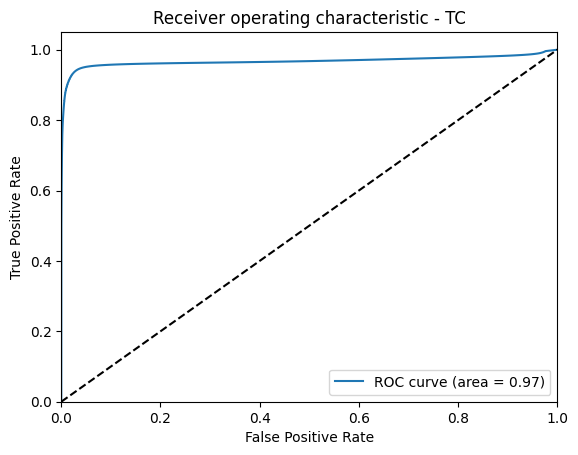

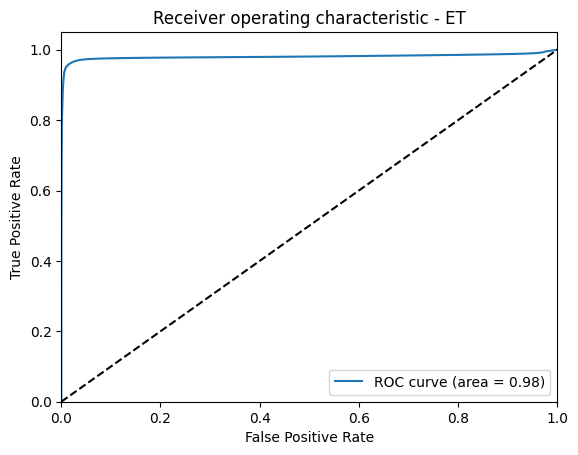

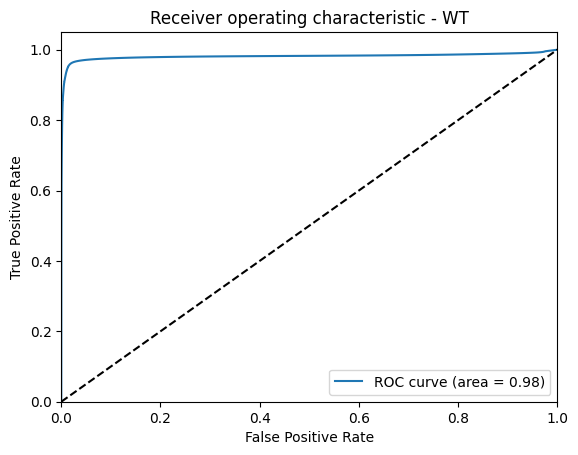

In [8]:
load(model, "weights/3D/3d_100e_adam_b4_bce_dice_upsampler")
visualize_model(model, sample_x)
print("3DUNet Upsampler with BCE-Dice Loss")
metrics(val_dl, model, DEVICE)

In [9]:
clear()
model = Base3DUNet(3, 3, features=[64, 128, 256, 512], up_sample=False).to(DEVICE)
print(f"total learnable parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


total learnable parameters = 90302147


C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


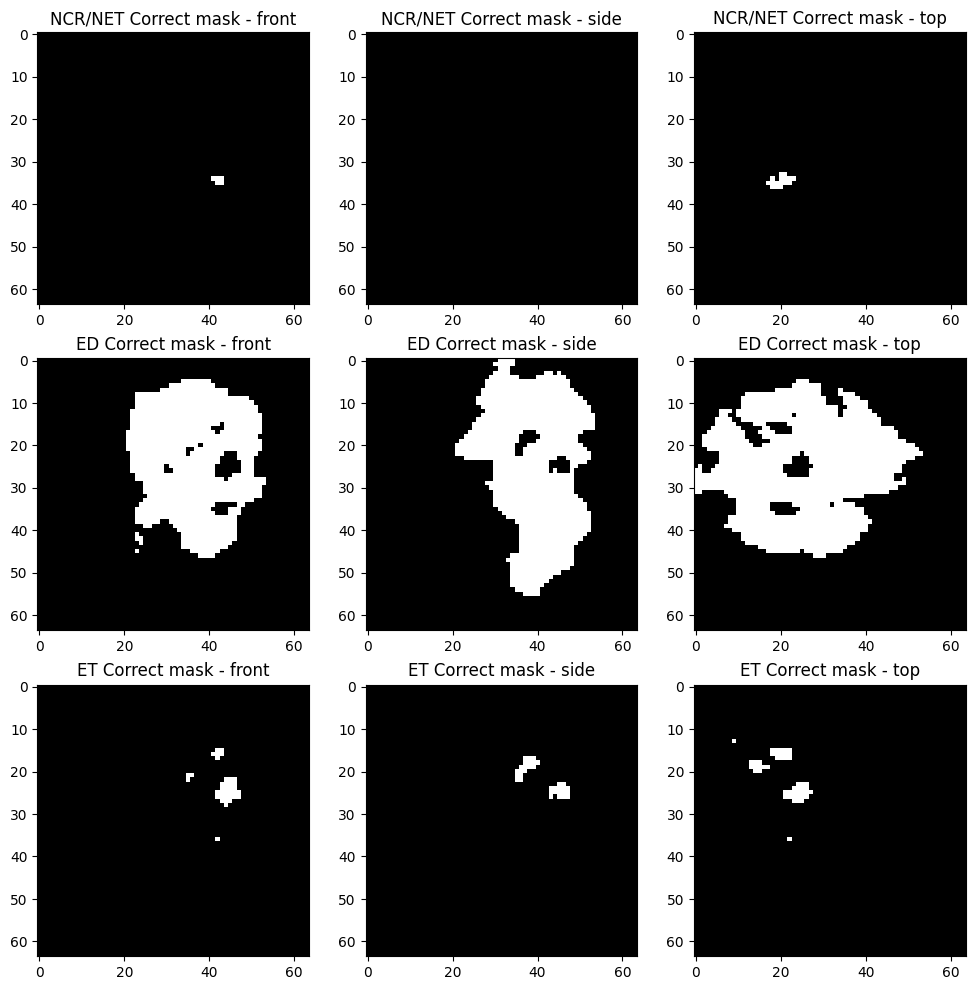

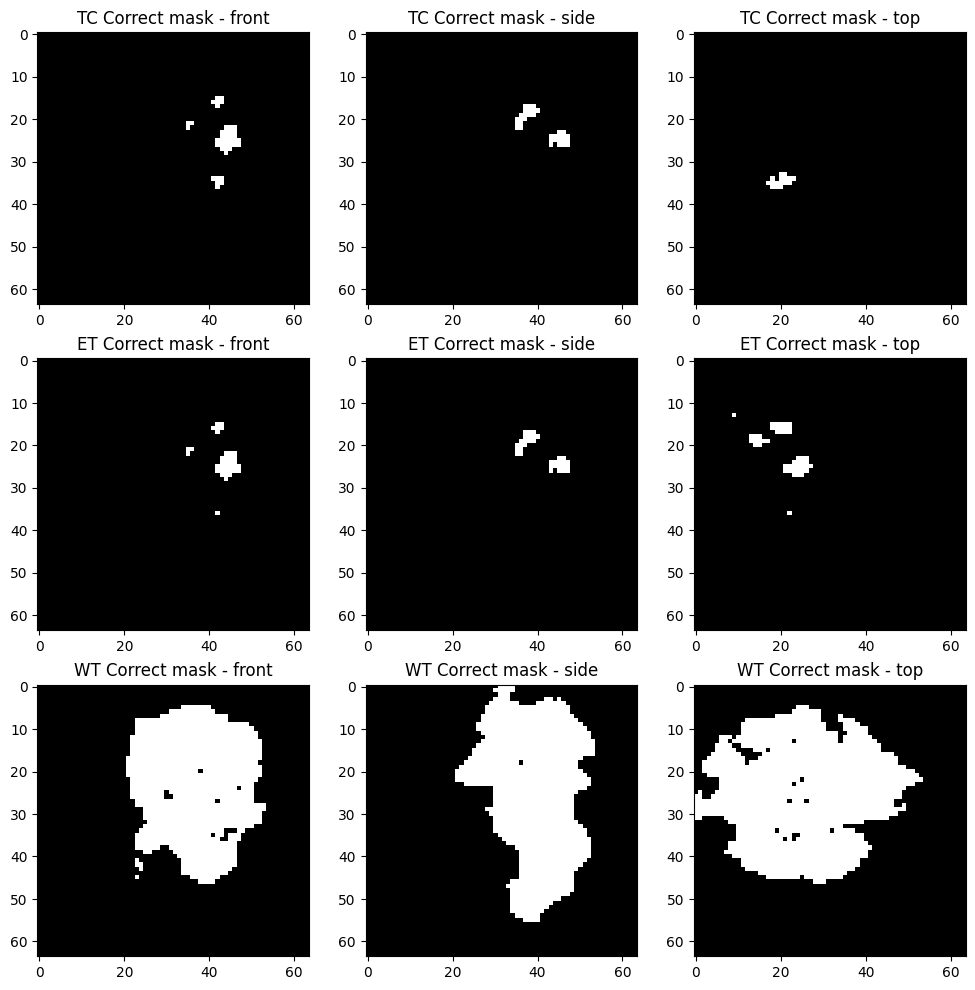

3DUNet with Dice Loss
 Accuracy (TC,ET,WT): 
 99.2832 , 99.6768, 99.0458
Dice Score (TC,ET,WT): 
 0.7510622143745422 , 0.6710379123687744, 0.8530760407447815
IoU Score (TC,ET,WT): 
 0.6535348892211914 , 0.5546413660049438, 0.7678035497665405
 Precision (TC,ET,WT): 
 --> 45.8908 , 97.4532, 14.7181
 Recall (TC,ET,WT): 
 --> 34.6282 , 78.0695, 14.9013
 F1-score (TC,ET,WT): 
 --> 39.4718 , 86.6910, 14.8092


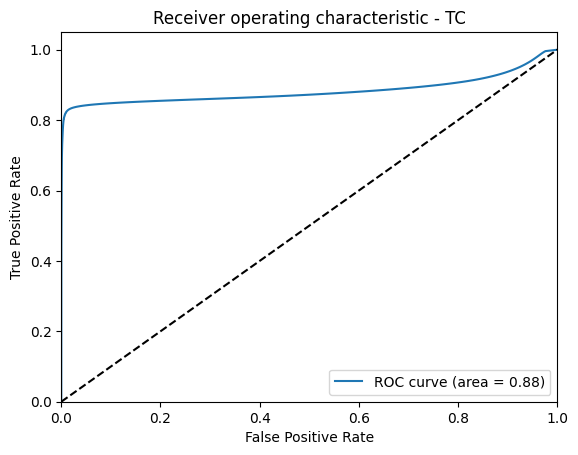

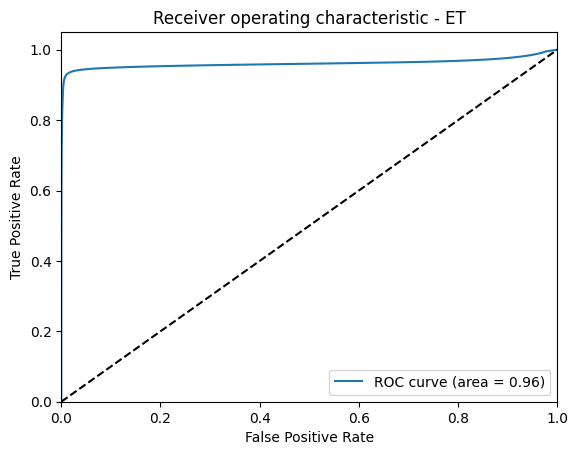

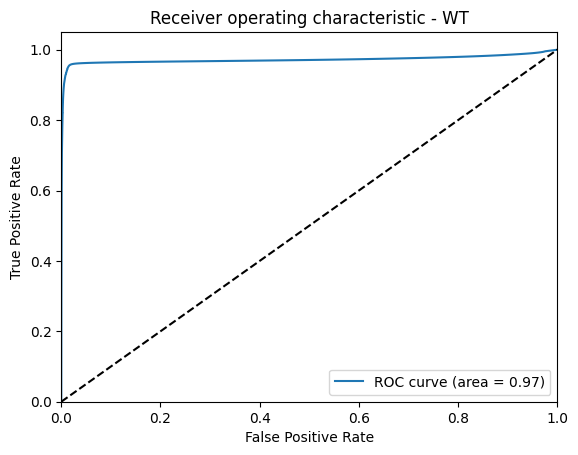

In [10]:
load(model, "weights/3D/3d_100e_adam_b4_dice")
visualize_model(model, sample_x)
print("3DUNet with Dice Loss")
metrics(val_dl, model, DEVICE)

C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


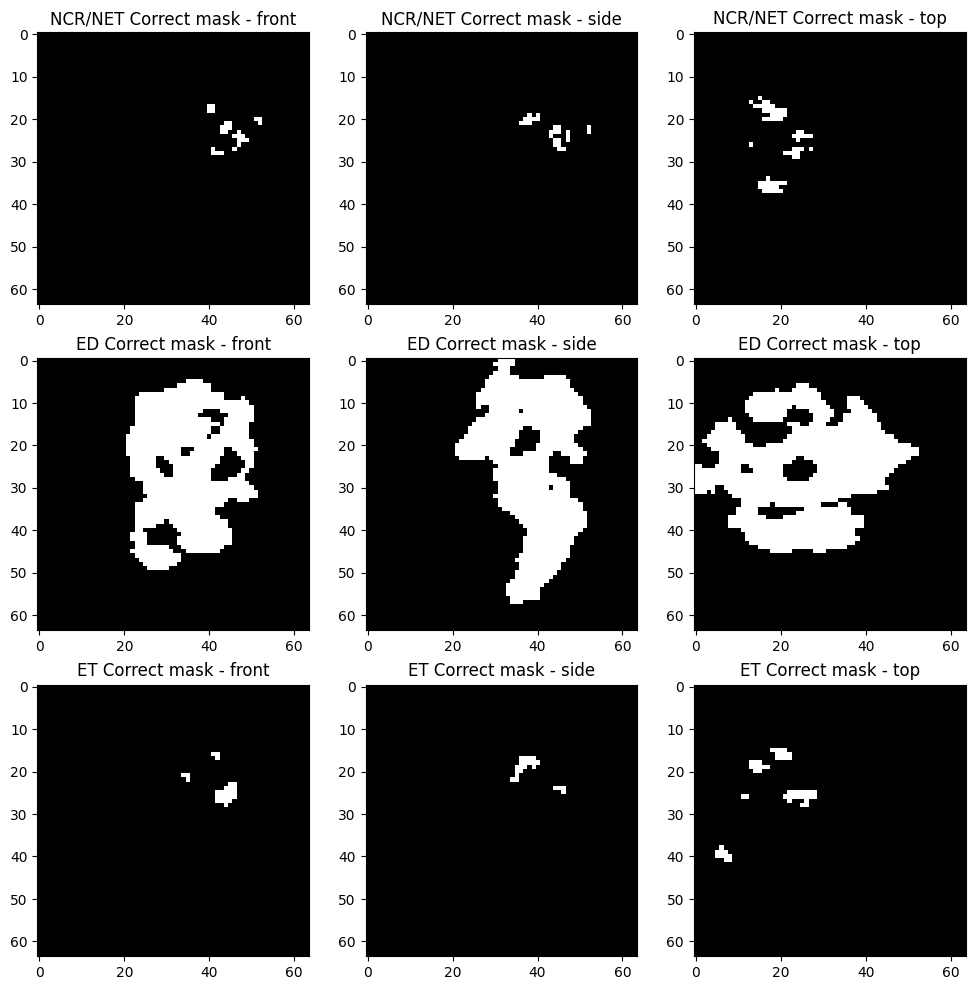

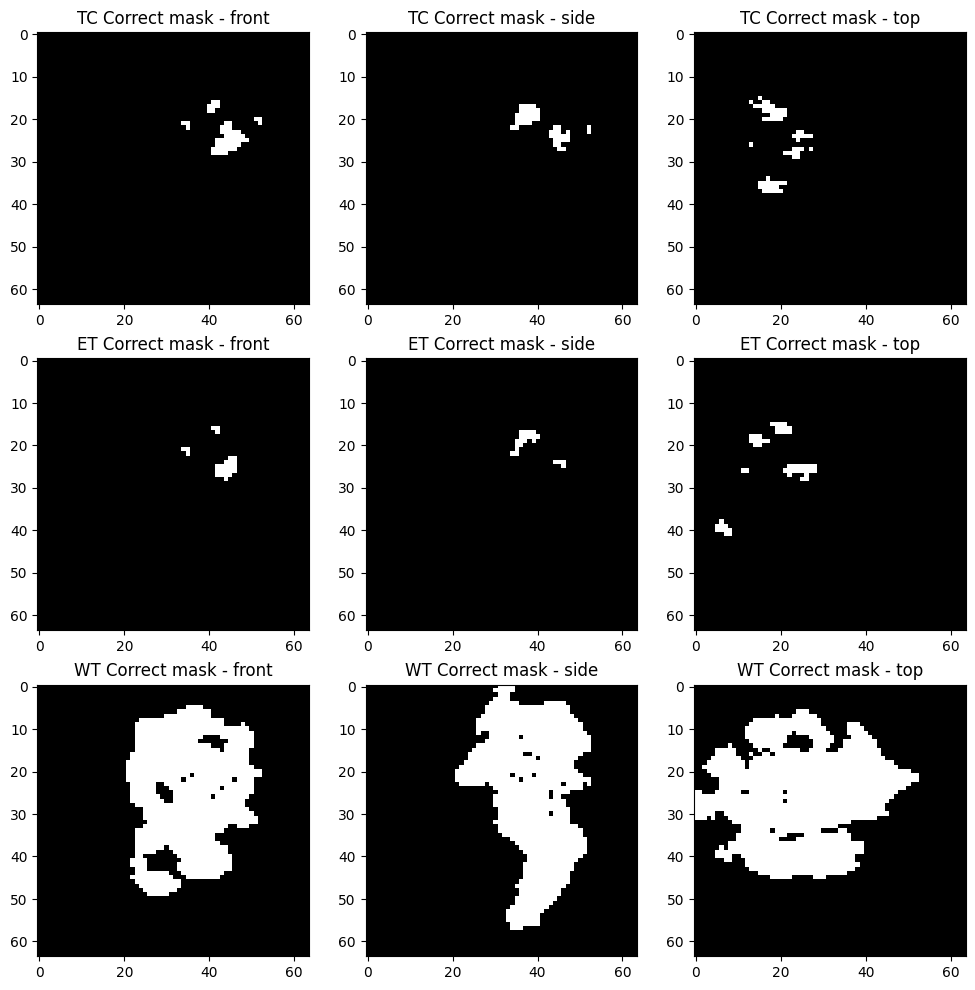

3DUNet with BCE-Dice Loss
 Accuracy (TC,ET,WT): 
 99.3641 , 99.7012, 99.1115
Dice Score (TC,ET,WT): 
 0.7842513918876648 , 0.6982654929161072, 0.8619918823242188
IoU Score (TC,ET,WT): 
 0.6884621381759644 , 0.5862982869148254, 0.7809391617774963
 Precision (TC,ET,WT): 
 --> 37.7861 , 85.5733, 15.7416
 Recall (TC,ET,WT): 
 --> 34.6564 , 78.0886, 14.9112
 F1-score (TC,ET,WT): 
 --> 36.1537 , 81.6598, 15.3152


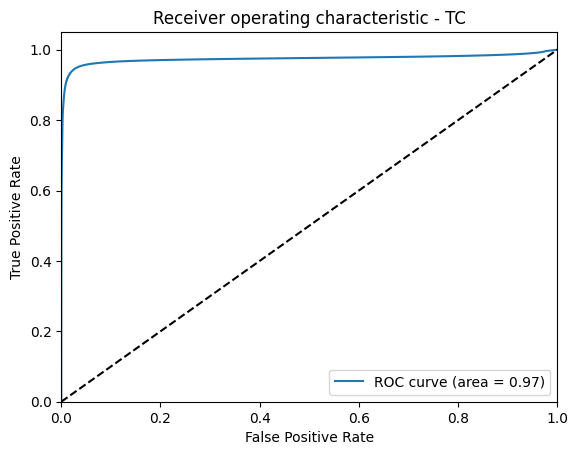

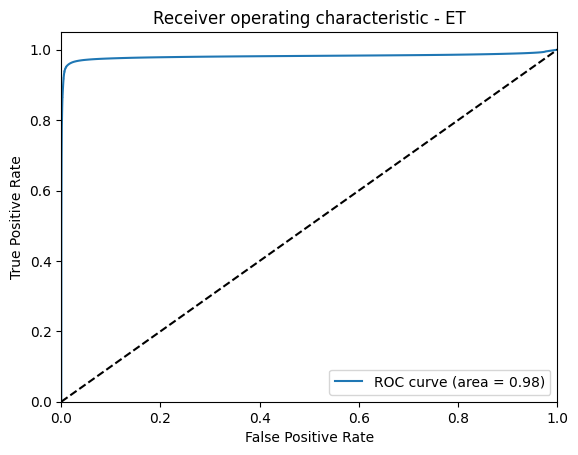

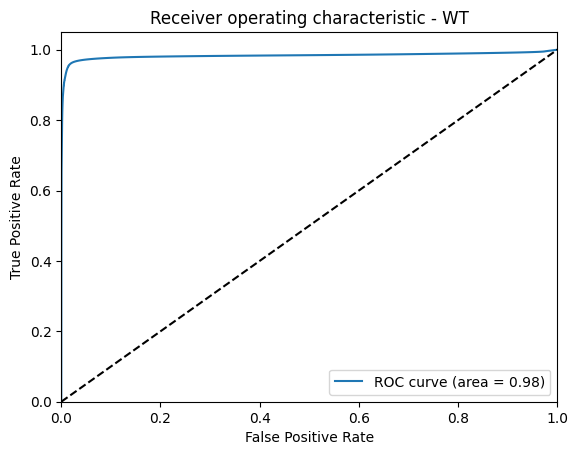

In [11]:
load(model, "weights/3D/3d_100e_adam_b4_bce_dice")
visualize_model(model, sample_x)
print("3DUNet with BCE-Dice Loss")
metrics(val_dl, model, DEVICE)

In [12]:
clear()
model = Attention3UNet(3, 3, features=[64, 128, 256, 512], up_sample=False).to(DEVICE)
print(f"total learnable parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


total learnable parameters = 91005199


C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


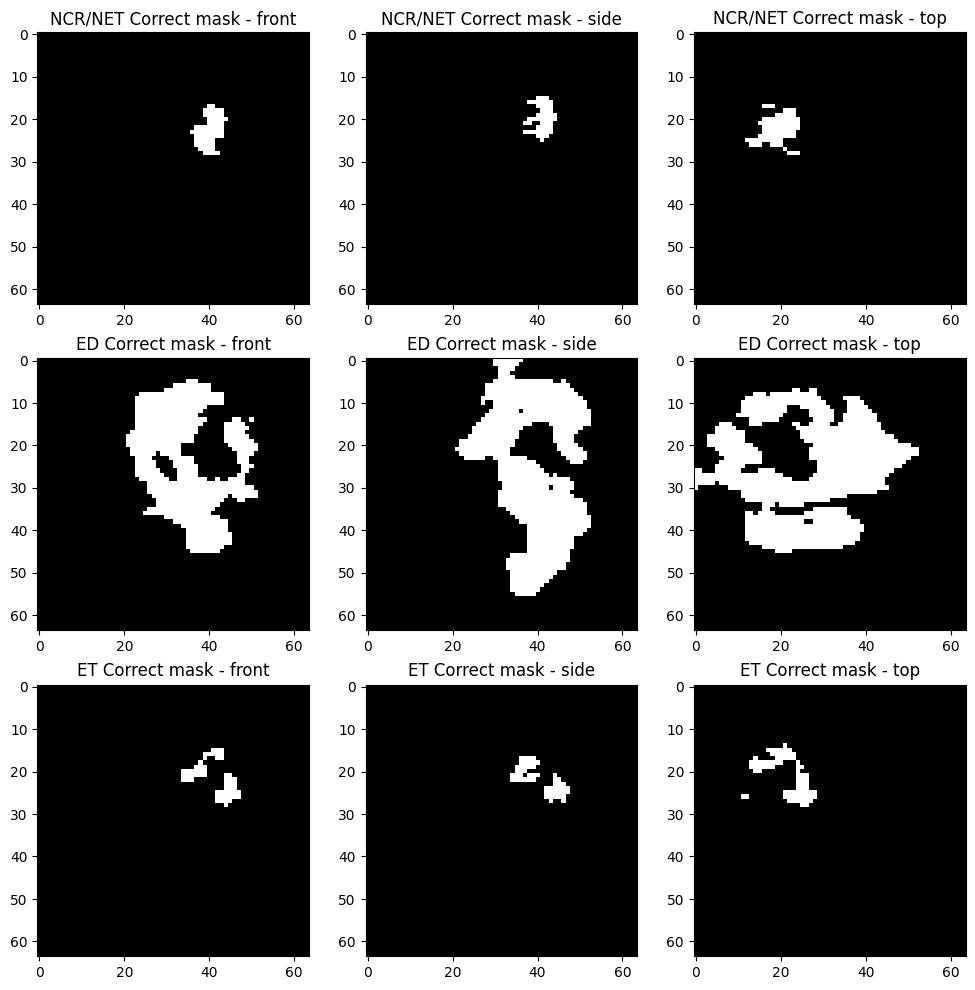

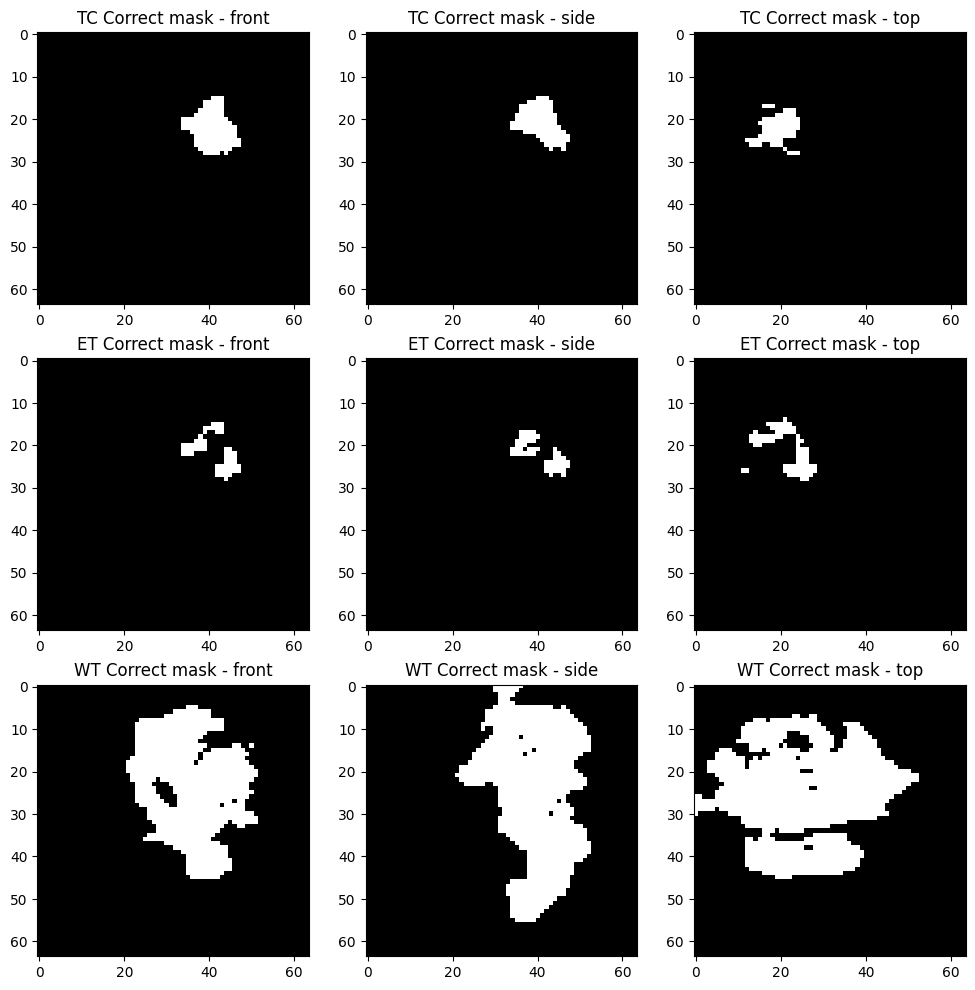

Attention3DUNet with Dice Loss - (ConvT version)
 Accuracy (TC,ET,WT): 
 99.3616 , 99.6905, 99.0768
Dice Score (TC,ET,WT): 
 0.7853401303291321 , 0.6932134628295898, 0.858309805393219
IoU Score (TC,ET,WT): 
 0.6910468935966492 , 0.5824634432792664, 0.7752197980880737
 Precision (TC,ET,WT): 
 --> 41.5087 , 82.9900, 15.8714
 Recall (TC,ET,WT): 
 --> 34.6555 , 78.0802, 14.9060
 F1-score (TC,ET,WT): 
 --> 37.7738 , 80.4603, 15.3736


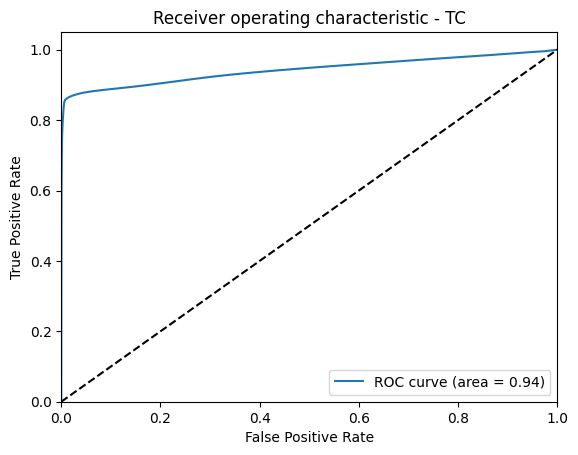

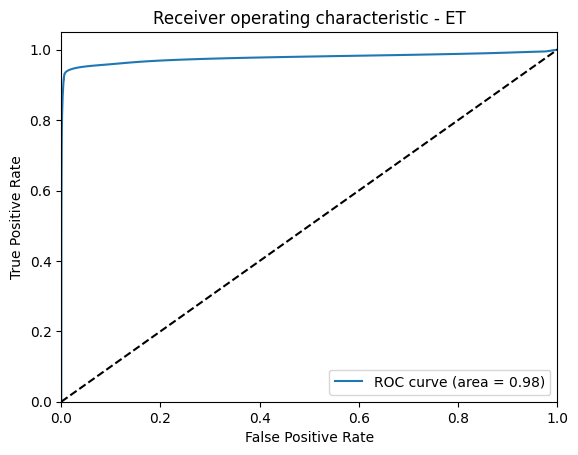

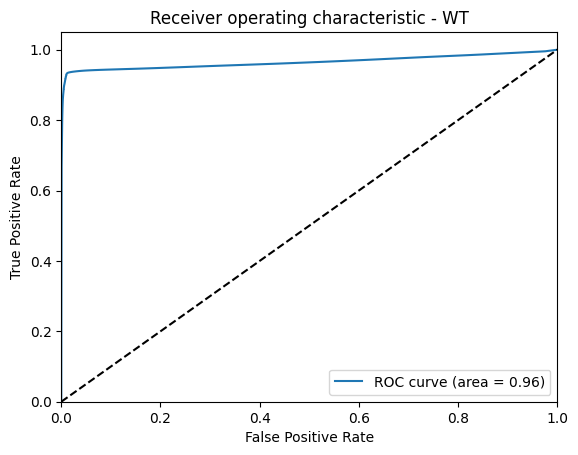

In [13]:
load(model, "weights/attention/att3d_100e_adam_b4_dice_c")
visualize_model(model, sample_x)
print("Attention3DUNet with Dice Loss - (ConvT version)")
metrics(val_dl, model, DEVICE)

C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


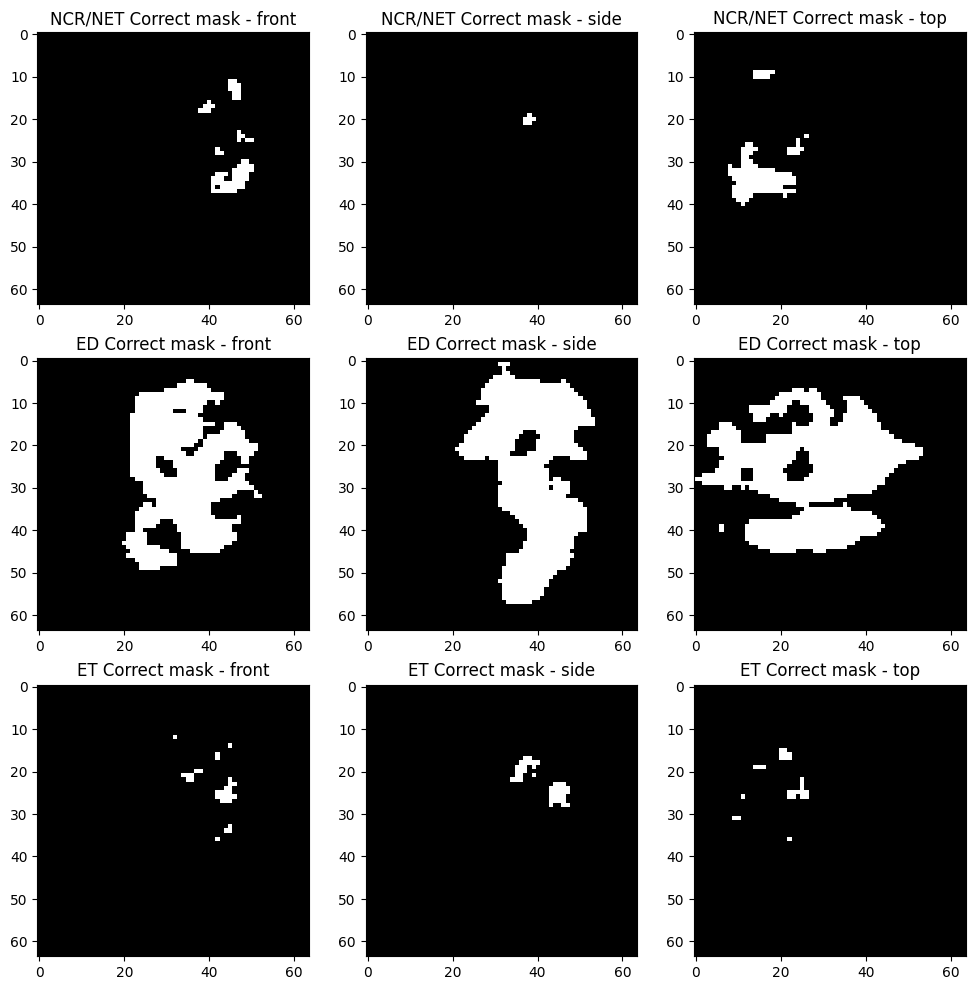

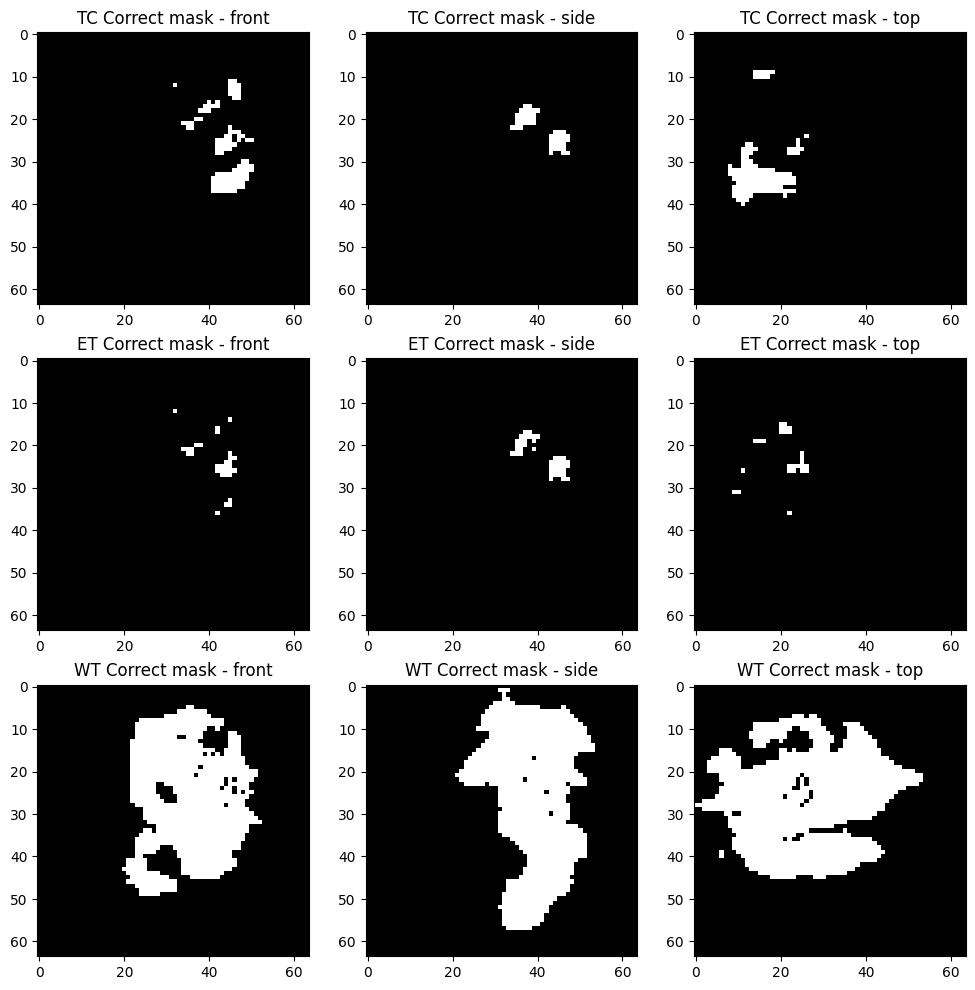

Attention3DUNet with BCE-Dice Loss - (ConvT version)
 Accuracy (TC,ET,WT): 
 99.3101 , 99.6922, 99.0717
Dice Score (TC,ET,WT): 
 0.7667142748832703 , 0.6907646059989929, 0.8530192971229553
IoU Score (TC,ET,WT): 
 0.6701188087463379 , 0.5782598257064819, 0.7718473672866821
 Precision (TC,ET,WT): 
 --> 40.9575 , 86.3042, 15.8607
 Recall (TC,ET,WT): 
 --> 34.6376 , 78.0815, 14.9052
 F1-score (TC,ET,WT): 
 --> 37.5334 , 81.9872, 15.3681


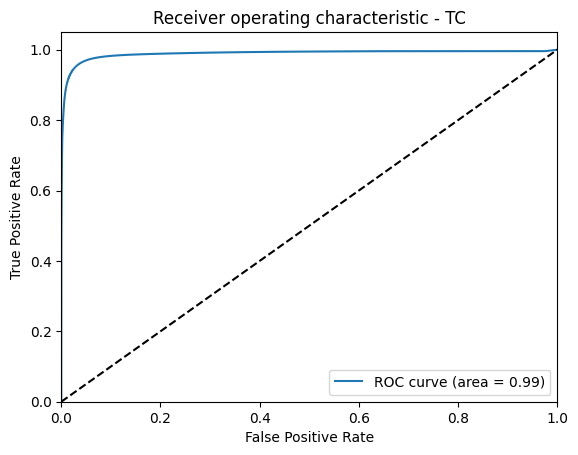

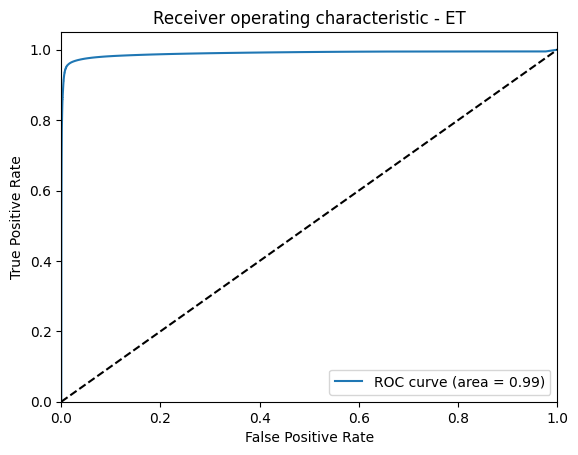

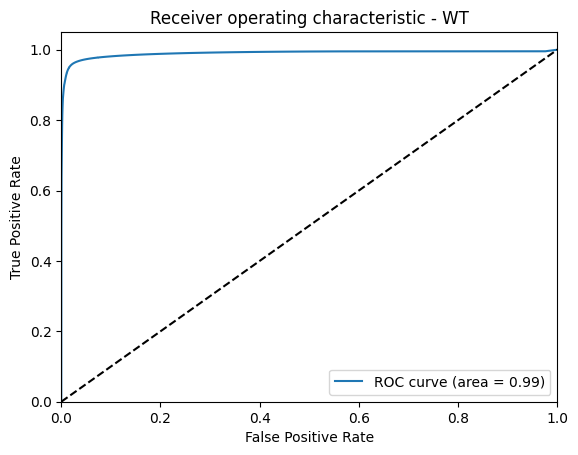

In [14]:
load(model, "weights/attention/att3d_100e_adam_b4_bce_dice_c")
visualize_model(model, sample_x)
print("Attention3DUNet with BCE-Dice Loss - (ConvT version)")
metrics(val_dl, model, DEVICE)

In [15]:
clear()
model = Attention3UNet(3, 3, features=[64, 128, 256, 512], up_sample=True).to(DEVICE)
print(f"total learnable parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


total learnable parameters = 95182159


C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


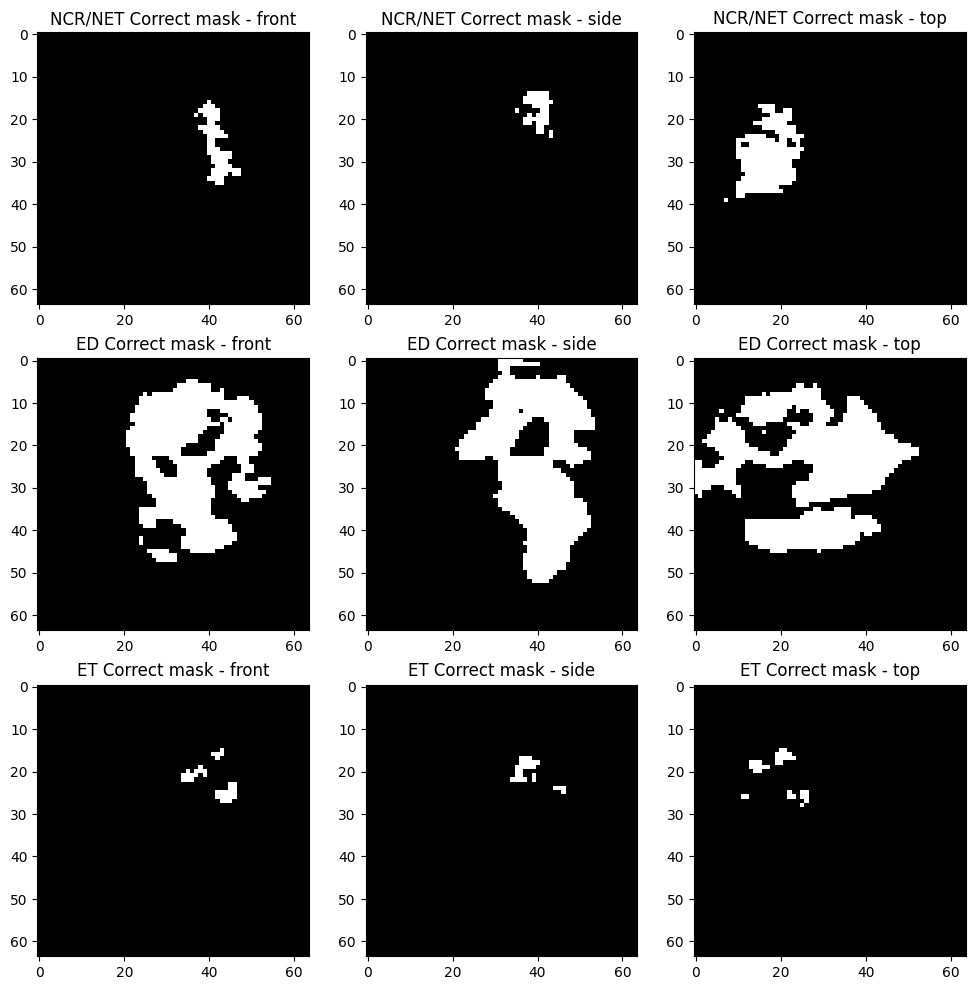

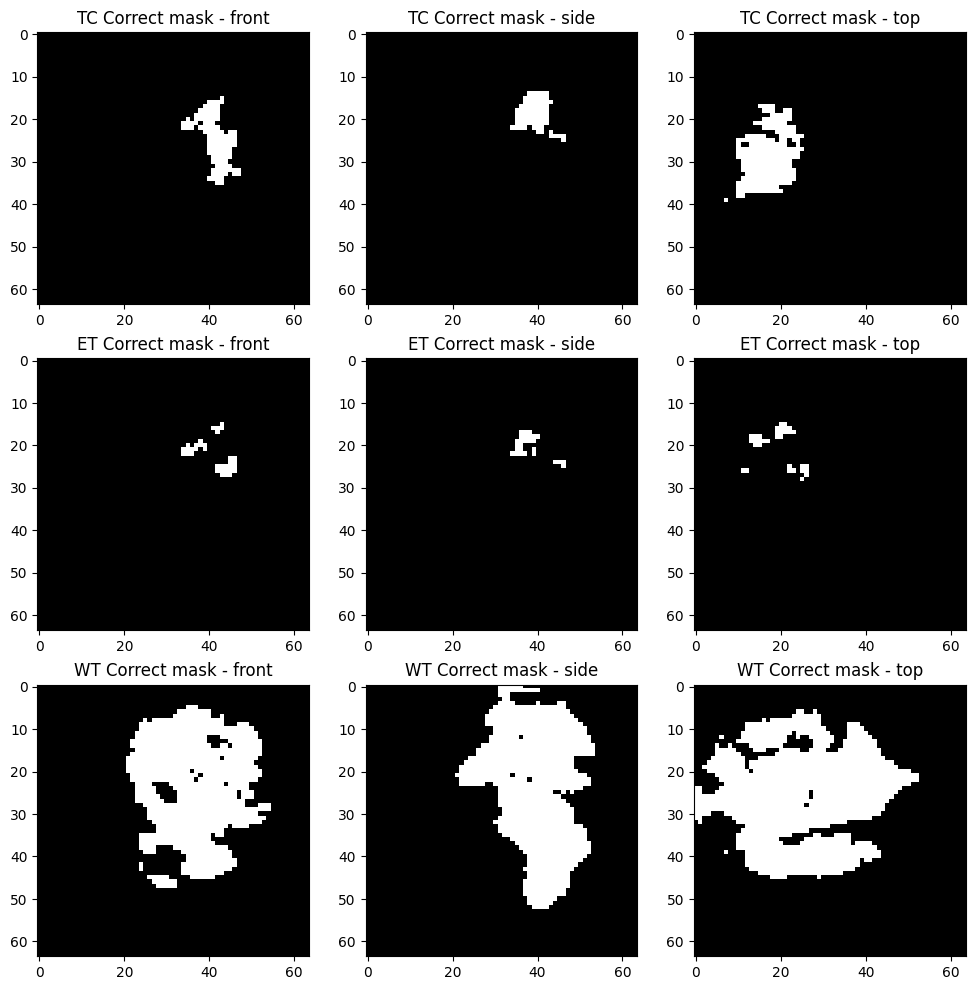

Attention3DUNet with Dice Loss - (Upsampler version)
 Accuracy (TC,ET,WT): 
 99.3416 , 99.6896, 99.0818
Dice Score (TC,ET,WT): 
 0.7849634885787964 , 0.6793321967124939, 0.8543657064437866
IoU Score (TC,ET,WT): 
 0.686598002910614 , 0.5670402646064758, 0.770800769329071
 Precision (TC,ET,WT): 
 --> 41.2086 , 92.9405, 16.3782
 Recall (TC,ET,WT): 
 --> 34.6486 , 78.0795, 14.9068
 F1-score (TC,ET,WT): 
 --> 37.6449 , 84.8643, 15.6079


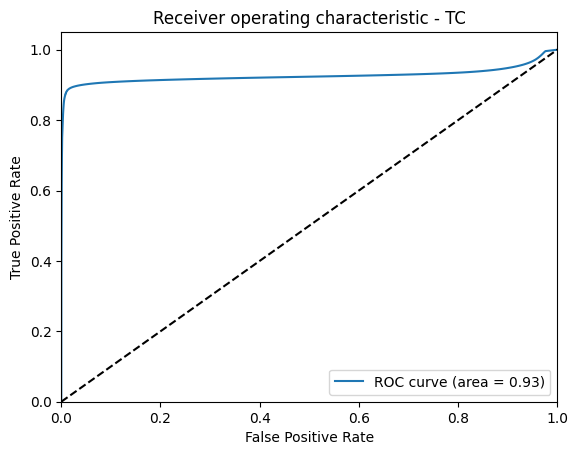

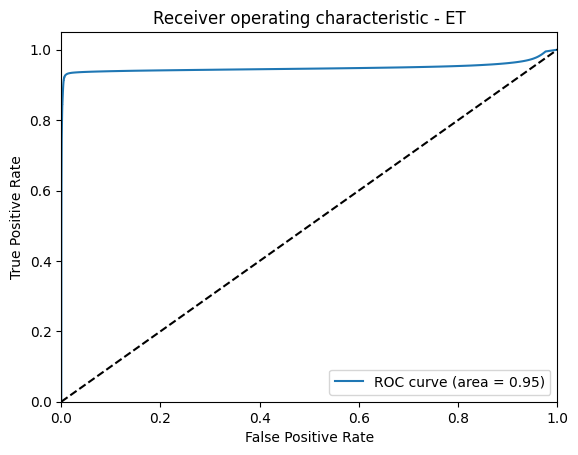

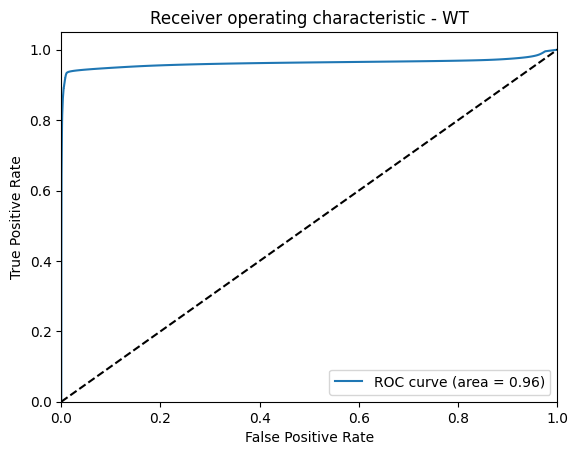

In [16]:
load(model, "weights/attention/att3d_100e_adam_b4_dice")
visualize_model(model, sample_x)
print("Attention3DUNet with Dice Loss - (Upsampler version)")
metrics(val_dl, model, DEVICE)

C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


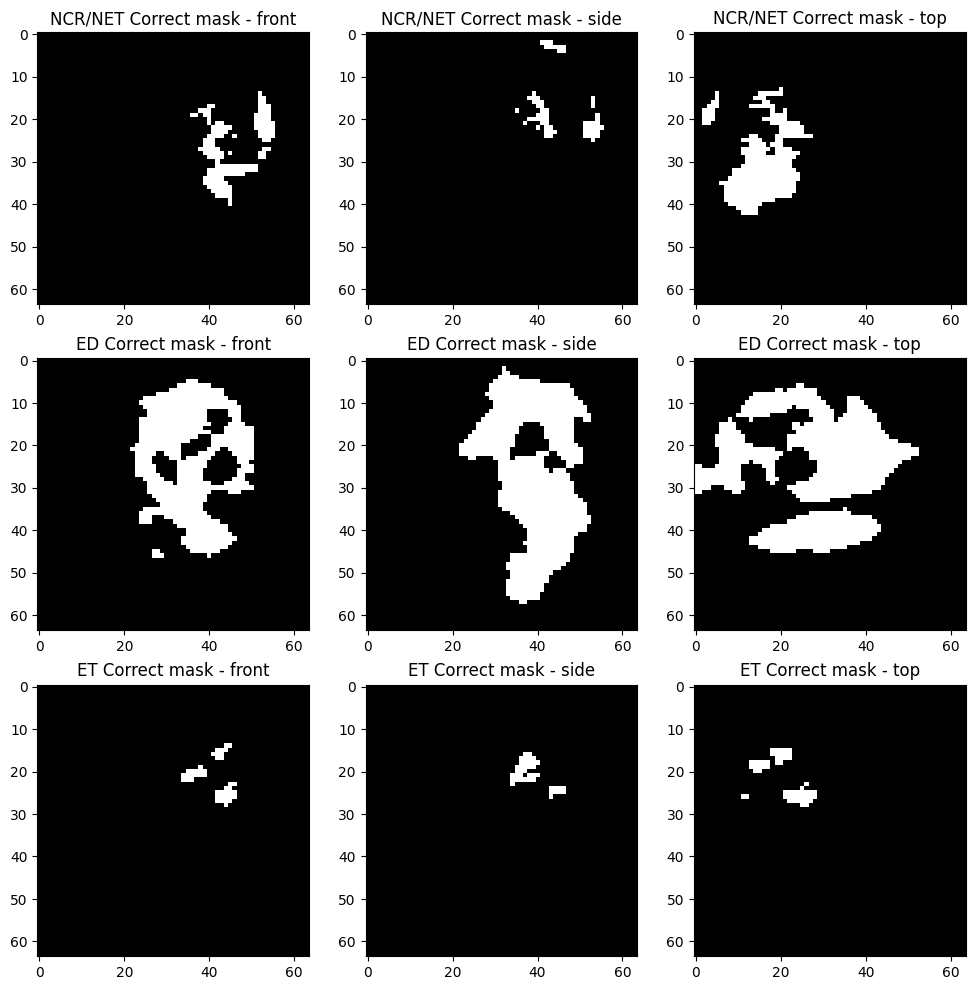

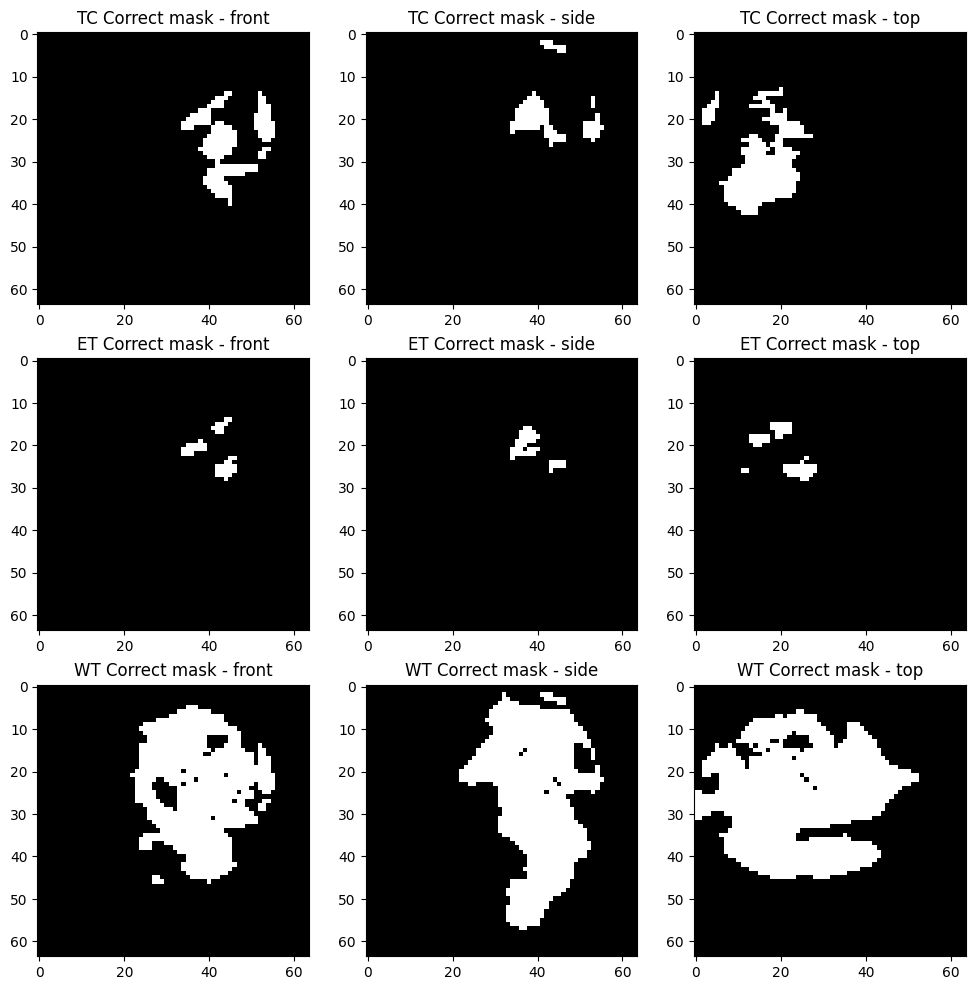

Attention3DUNet with BCE-Dice Loss - (Upsampler version)
 Accuracy (TC,ET,WT): 
 99.3411 , 99.6839, 99.0623
Dice Score (TC,ET,WT): 
 0.7831154465675354 , 0.6768758893013, 0.8526276350021362
IoU Score (TC,ET,WT): 
 0.6861838102340698 , 0.5659211277961731, 0.768965482711792
 Precision (TC,ET,WT): 
 --> 41.9782 , 89.8057, 16.3320
 Recall (TC,ET,WT): 
 --> 34.6484 , 78.0750, 14.9038
 F1-score (TC,ET,WT): 
 --> 37.9627 , 83.5305, 15.5853


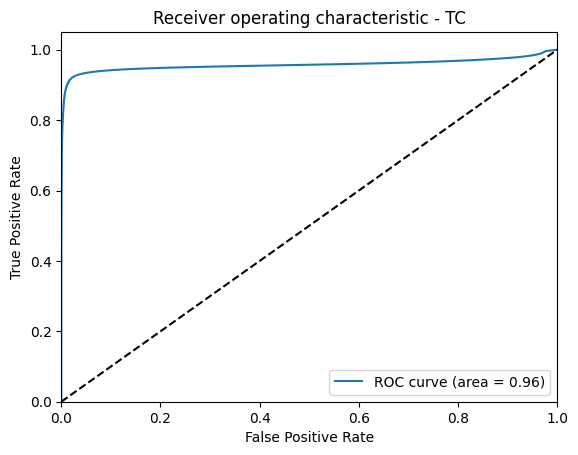

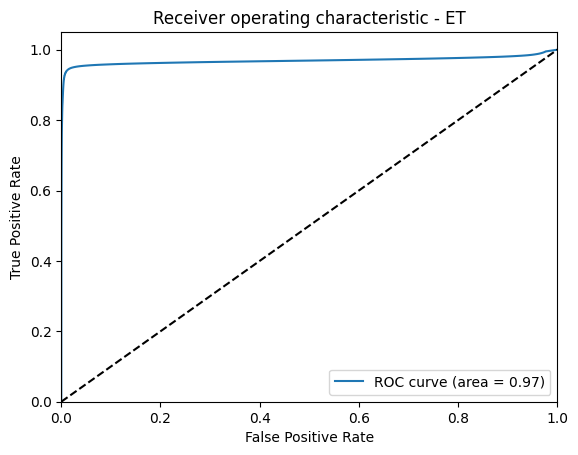

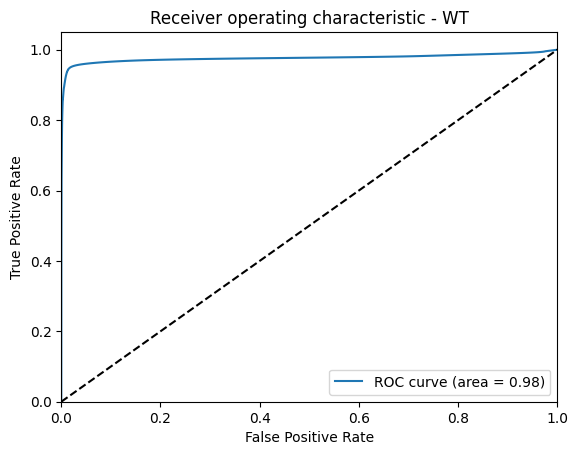

In [17]:
load(model, "weights/attention/att3d_100e_adam_b4_bce_dice")
visualize_model(model, sample_x)
print("Attention3DUNet with BCE-Dice Loss - (Upsampler version)")
metrics(val_dl, model, DEVICE)

In [18]:
clear()
model = Res3DUNet(3, 3).to(DEVICE)
print(f"total learnable parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


total learnable parameters = 95882563


C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


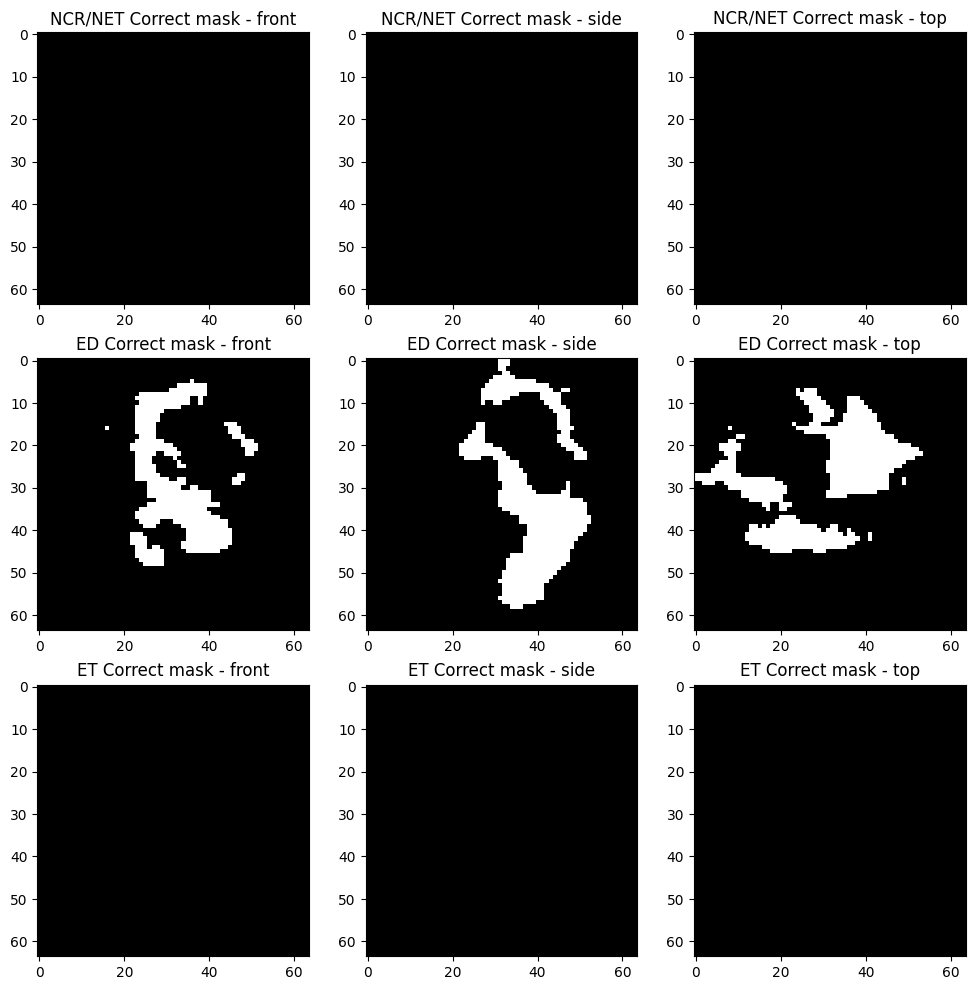

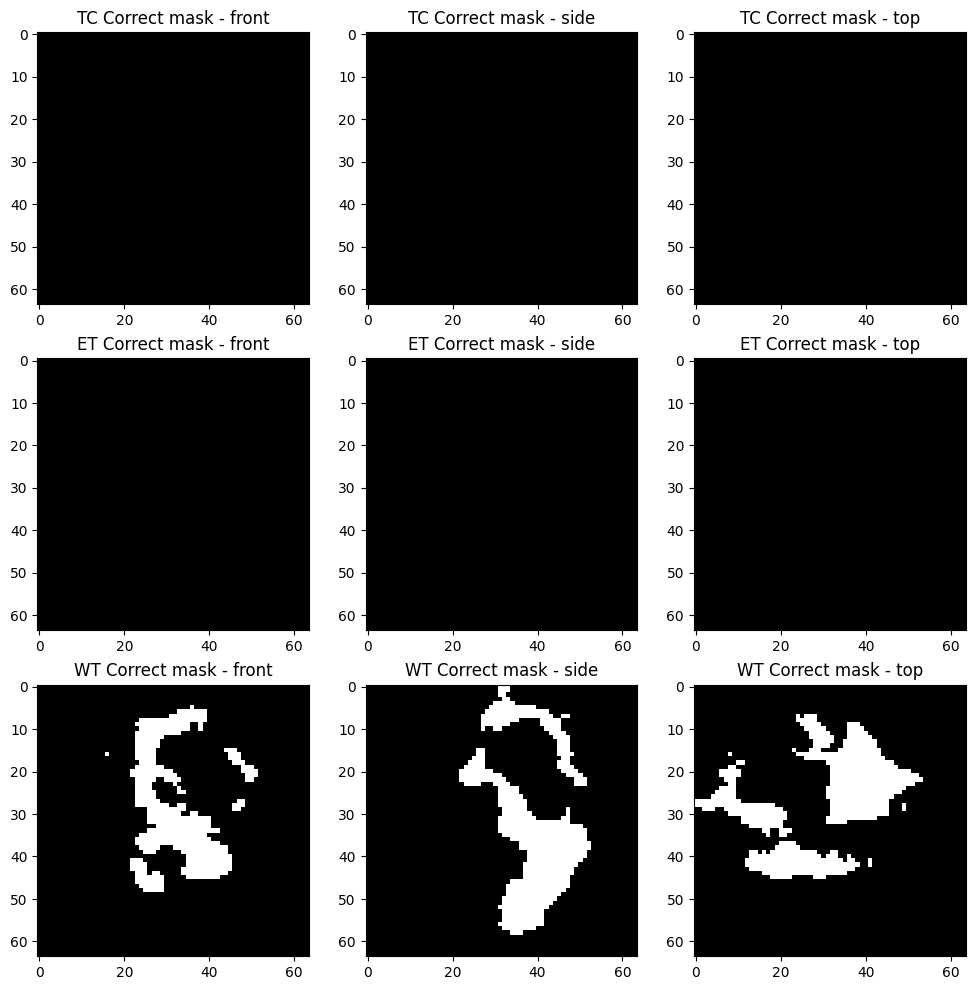

Residual3DUNet with Dice Loss
 Accuracy (TC,ET,WT): 
 98.0628 , 99.1373, 97.4300
Dice Score (TC,ET,WT): 
 0.0 , 0.0, 0.5960832834243774
IoU Score (TC,ET,WT): 
 0.0 , 0.0, 0.445268839597702
 Precision (TC,ET,WT): 
 --> inf , inf, 25.8460
 Recall (TC,ET,WT): 
 --> 34.2025 , 77.6469, 14.6583
 F1-score (TC,ET,WT): 
 --> nan , nan, 18.7070


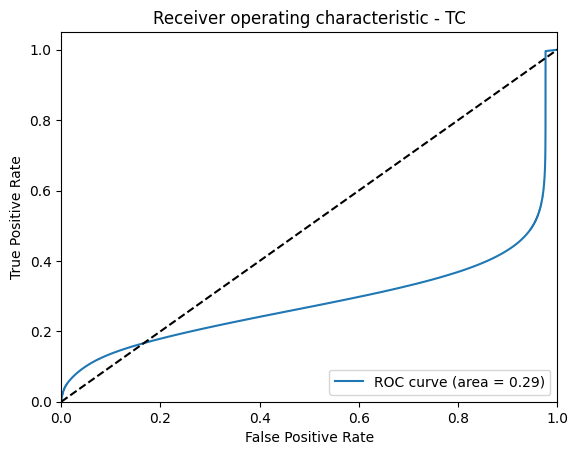

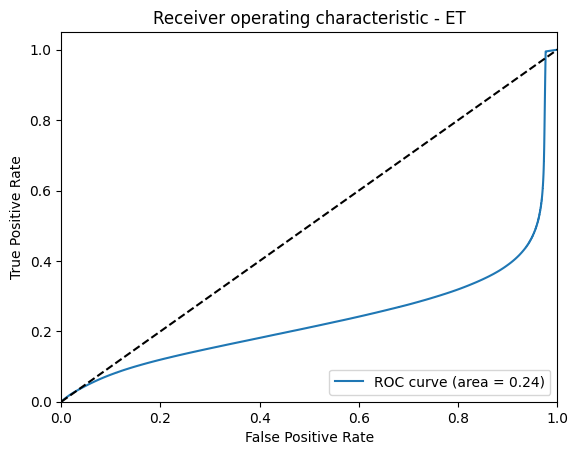

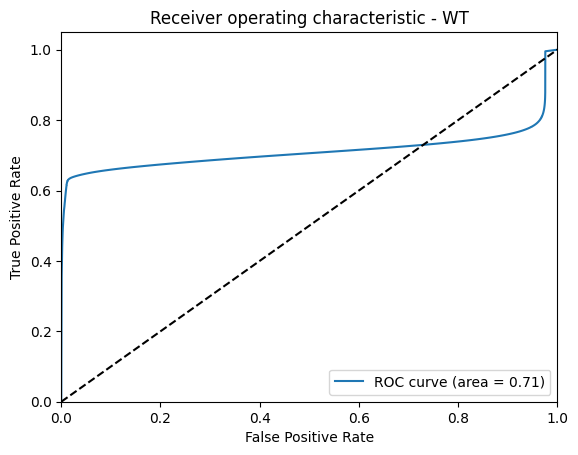

In [19]:
load(model, "weights/residual/3d_res_4layer_100e_adam_dice")
visualize_model(model, sample_x)
print("Residual3DUNet with Dice Loss")
metrics(val_dl, model, DEVICE)

C:\Users\Shayan\AppData\Local\Temp\ipykernel_14572\3946436967.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sample_x.unsqueeze(0))


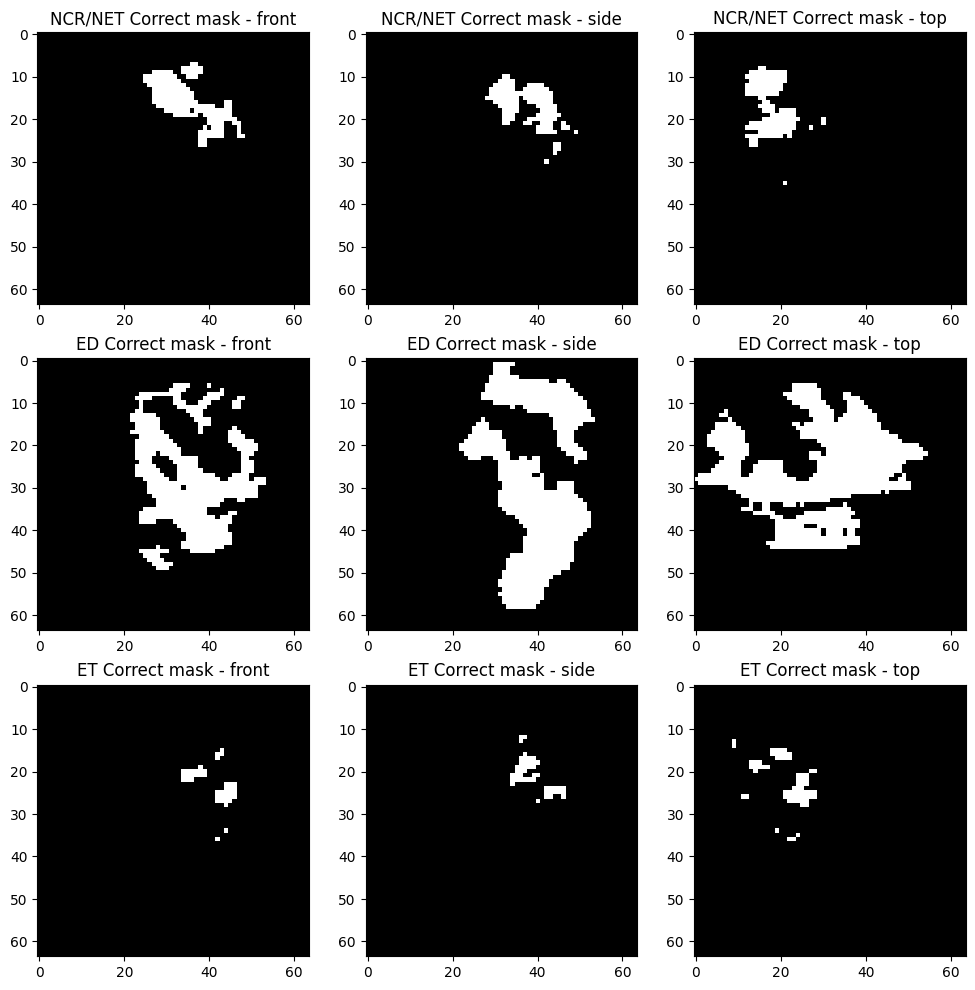

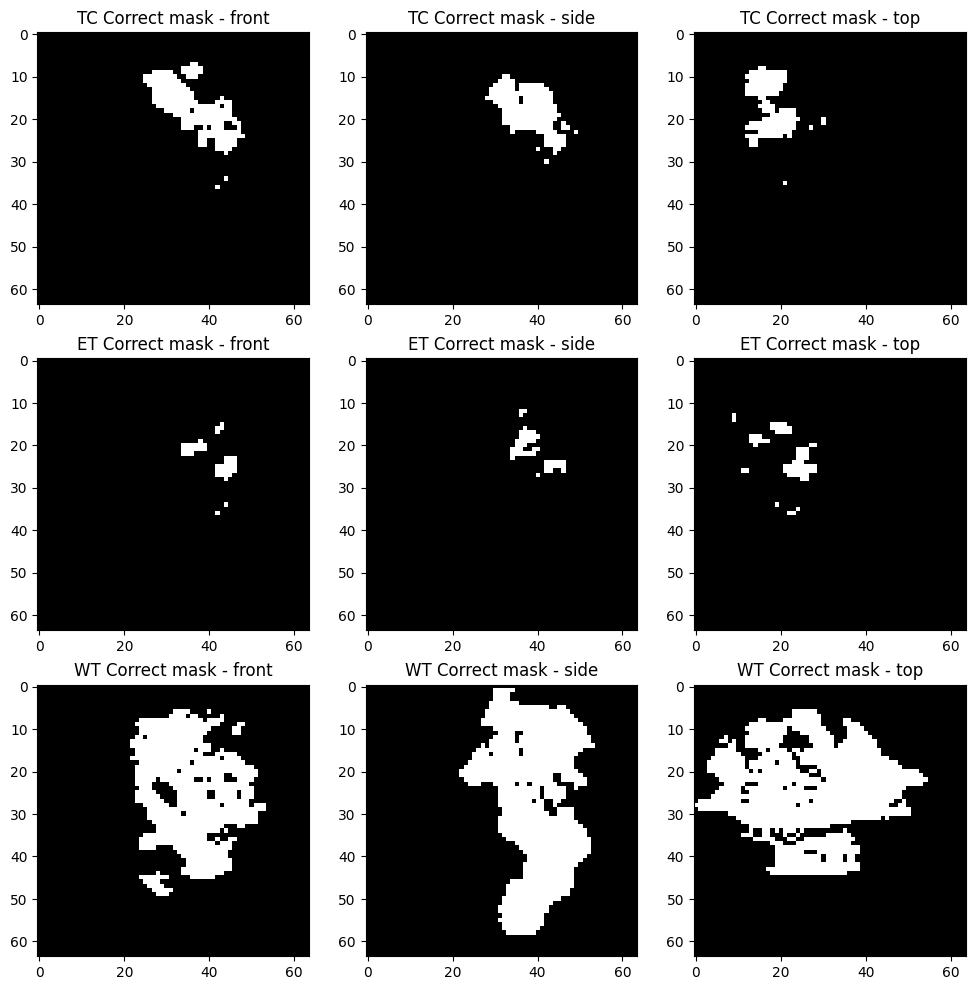

Residual3DUNet with BCE-Dice Loss
 Accuracy (TC,ET,WT): 
 99.2880 , 99.6664, 99.0038
Dice Score (TC,ET,WT): 
 0.7535775899887085 , 0.6737334132194519, 0.840580940246582
IoU Score (TC,ET,WT): 
 0.6482313275337219 , 0.5583898425102234, 0.7521806359291077
 Precision (TC,ET,WT): 
 --> 43.2785 , 89.2285, 16.0607
 Recall (TC,ET,WT): 
 --> 34.6299 , 78.0613, 14.8950
 F1-score (TC,ET,WT): 
 --> 38.4741 , 83.2722, 15.4559


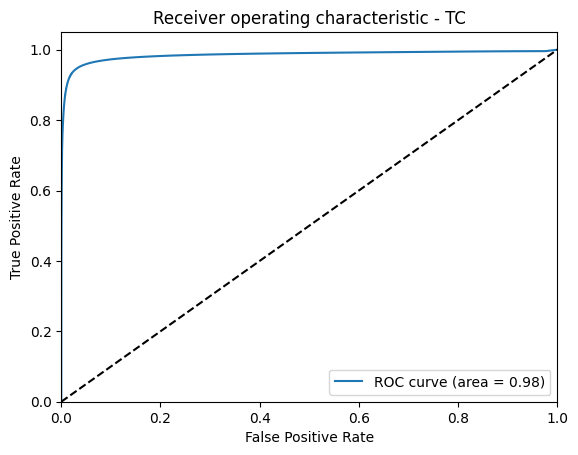

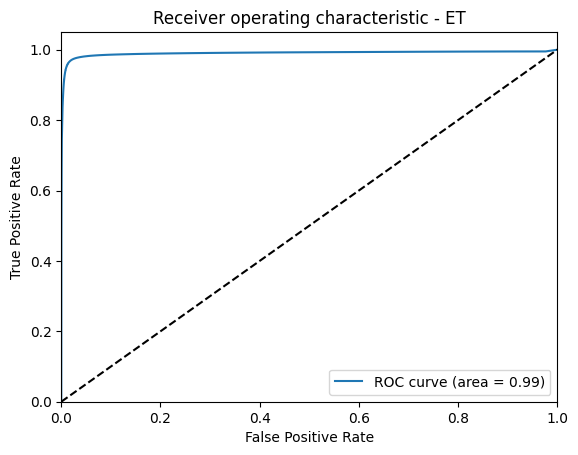

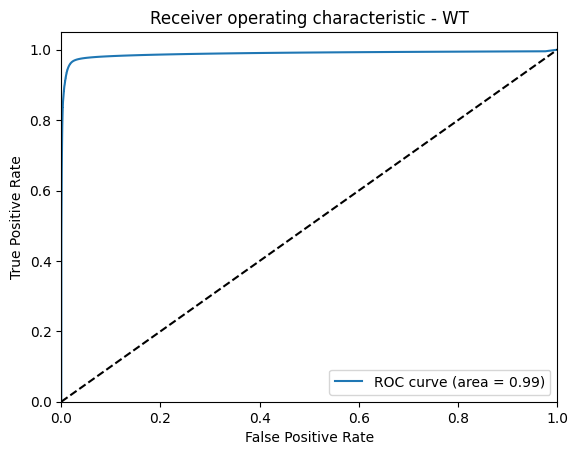

In [20]:
load(model, "weights/residual/3d_res_4layer_100e_adam_bce_dice")
visualize_model(model, sample_x)
print("Residual3DUNet with BCE-Dice Loss")
metrics(val_dl, model, DEVICE)

### End of metrics - the loss changes

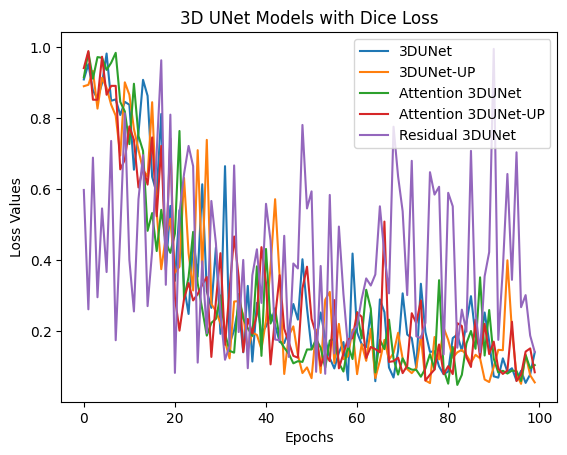

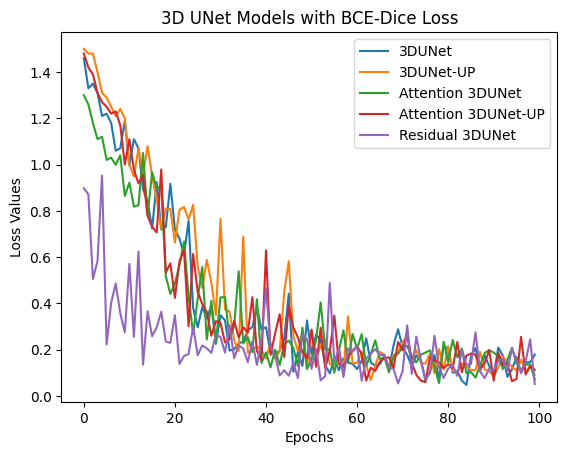

In [45]:
def read_losses(path):
    file = open(path)
    lines = file.readlines()
    losses = []
    for line in lines:
        if line.startswith("At epoch"):

            try:
                loss = float(line.strip().split(" ")[-1].split("=")[1].split("]")[0])
                losses.append(loss)
            except:
                print(f"-{line}-")


    return losses

base_dice = read_losses("loss-logs/logs-base-dice.txt")
base_bcedice = read_losses("loss-logs/logs-base-bce-dice.txt")
base_bcedice_u = read_losses("loss-logs/logs-base-upsample-bce-dice.txt")
base_dice_u = read_losses("loss-logs/logs-base-upsample-dice.txt")

att_dice_u = read_losses("loss-logs/logs-att-dice.txt")
att_bcedice_u = read_losses("loss-logs/logs-att-bce-dice.txt")
att_dice = read_losses("loss-logs/logs-att-convT-dice.txt")
att_bcedice = read_losses("loss-logs/logs-att-convT-bce-dice.txt")

res_dice =  read_losses("loss-logs/logs-res-dice.txt")
res_bcedice =  read_losses("loss-logs/logs-res-bce-dice.txt")

fig, ax = plt.subplots()
ax.set_title('3D UNet Models with Dice Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss Values')
ax.plot(base_dice, label='3DUNet')
ax.plot(base_dice_u, label='3DUNet-UP')
ax.plot(att_dice, label='Attention 3DUNet')
ax.plot(att_dice_u, label='Attention 3DUNet-UP')
ax.plot(res_dice, label='Residual 3DUNet')
ax.legend()

plt.show()

fig, ax = plt.subplots()
ax.set_title('3D UNet Models with BCE-Dice Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss Values')
ax.plot(base_bcedice, label='3DUNet')
ax.plot(base_bcedice_u, label='3DUNet-UP')
ax.plot(att_bcedice, label='Attention 3DUNet')
ax.plot(att_bcedice_u, label='Attention 3DUNet-UP')
ax.plot(res_bcedice, label='Residual 3DUNet')
ax.legend()

plt.show()